In [2]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.ml.stat import Correlation

from tqdm import tqdm  # For progress bars
from google.colab import drive
drive.mount('/content/drive')
# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder \
    .appName("HomeCredit_EDA") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "10g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.2") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.sql.shuffle.partitions", "12") \
    .config("spark.default.parallelism", "12") \
    .getOrCreate()

Mounted at /content/drive


# 1. Importing database

In [3]:
# List of all data files to import
filename = [
    'application_train',    # Main training data with target variable
    'bureau',               # Credit bureau data
    'bureau_balance',       # Monthly bureau balance data
    'credit_card_balance',  # Credit card monthly balance
    'installments_payments', # Payment history data
    'POS_CASH_balance',     # Point of sale and cash loan data
    'previous_application'  # Previous application data
]

# Dictionary to store all dataframes
data = {}

# Import all files into dictionary
for file in tqdm(filename):
    if file in data.keys():
        print(f'{file} already exists in dictionary')
    else:
        filepath = '/content/drive/MyDrive/Home_Credit/'+f'{file}.csv'
        df = spark.read.csv(filepath, header=True, sep=',', inferSchema=True)
        data[file] = df

100%|██████████| 7/7 [01:41<00:00, 14.55s/it]


## 1.1. Summarizing dataframes

In [4]:
"""
Create a summary table showing number of columns and observations in each dataframe
"""
summary_results = []
for key in data.keys():
    summary_results.append([key, len(data[key].columns), data[key].count()])
dataframe_summary = pd.DataFrame(summary_results, columns=['Dataframe', 'Number of columns', 'Number of observations'])
dataframe_summary

,Dataframe,Number of columns,Number of observations
0,application_train,122,307511
1,bureau,17,1716428
2,bureau_balance,3,27299925
3,credit_card_balance,23,3840312
4,installments_payments,8,13605401
5,POS_CASH_balance,8,10001358
6,previous_application,37,1670214


## 1.2. Missing values counting

In [5]:
def analyze_missing_data(dataframe_name):
    """
    Analyze missing values in a dataframe

    Args:
        dataframe_name: Name of the dataframe in the data dictionary

    Returns:
        DataFrame with missing value counts and percentages
    """
    df = data[dataframe_name]
    # Count nulls in each column
    missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
    # Add a row identifier and transpose
    missing_df = missing_counts.withColumn('Column', lit('Total')).toPandas().set_index('Column').transpose()
    # Calculate percentage
    missing_df['Percent'] = (missing_df['Total']*100/df.count()).round(2)
    return missing_df

In [6]:
# Analyze missing values in each dataframe
print('Top 20 variables with missing values in each dataframe:')
for df_name in filename:
    missing_df = analyze_missing_data(df_name)
    print(f'\n{df_name.upper()} with total {data[df_name].count()} observations:')
    print(missing_df.sort_values('Total', ascending=False).head(20))

Top 20 variables with missing values in each dataframe:

APPLICATION_TRAIN with total 307511 observations:
Column                     Total  Percent
COMMONAREA_AVG            214865    69.87
COMMONAREA_MODE           214865    69.87
COMMONAREA_MEDI           214865    69.87
NONLIVINGAPARTMENTS_MEDI  213514    69.43
NONLIVINGAPARTMENTS_MODE  213514    69.43
NONLIVINGAPARTMENTS_AVG   213514    69.43
FONDKAPREMONT_MODE        210295    68.39
LIVINGAPARTMENTS_AVG      210199    68.35
LIVINGAPARTMENTS_MEDI     210199    68.35
LIVINGAPARTMENTS_MODE     210199    68.35
FLOORSMIN_MODE            208642    67.85
FLOORSMIN_AVG             208642    67.85
FLOORSMIN_MEDI            208642    67.85
YEARS_BUILD_AVG           204488    66.50
YEARS_BUILD_MODE          204488    66.50
YEARS_BUILD_MEDI          204488    66.50
OWN_CAR_AGE               202929    65.99
LANDAREA_MEDI             182590    59.38
LANDAREA_AVG              182590    59.38
LANDAREA_MODE             182590    59.38

BUREAU wit

# 2. RELATIONSHIP BETWEEN DATAFRAMES

- **SK_ID_CURR** connects the dataframes *application_train|test*, *bureau*, *previous_application*, *POS_CASH_balance*, *installments_payment* and *credit_card_balance*

- **SK_ID_PREV** connects the dataframes *previous_application*, *POS_CASH_balance*, *installments_payment* and *credit_card_balance*

- **SK_ID_PREV** connects the dataframes *bureau* and *bureau_balance*


In [7]:
# Display relationship information
relationship_table = []
for df_name in filename:
    # Count distinct SK_ID_CURR
    if 'SK_ID_CURR' in data[df_name].columns:
        distinct_curr = data[df_name].select(F.countDistinct("SK_ID_CURR")).collect()[0][0]
    else:
        distinct_curr = 0

    # Count distinct SK_ID_PREV
    if 'SK_ID_PREV' in data[df_name].columns:
        distinct_prev = data[df_name].select(F.countDistinct("SK_ID_PREV")).collect()[0][0]
    else:
        distinct_prev = 0

    relationship_table.append([df_name, data[df_name].count(), distinct_curr, distinct_prev])

# Create relationship summary table
relationship_summary = pd.DataFrame(relationship_table,
                                  columns=['Dataframe', 'Total_Rows', 'Distinct_SK_ID_CURR', 'Distinct_SK_ID_PREV'])
relationship_summary

,Dataframe,Total_Rows,Distinct_SK_ID_CURR,Distinct_SK_ID_PREV
0,application_train,307511,307511,0
1,bureau,1716428,305811,0
2,bureau_balance,27299925,0,0
3,credit_card_balance,3840312,103558,104307
4,installments_payments,13605401,339587,997752
5,POS_CASH_balance,10001358,337252,936325
6,previous_application,1670214,338857,1670214


 VISUALIZATION FUNCTIONS

In [8]:
def plot_dist_TARGET(data_frame, variables, num_rows):
    """
    Plot distribution of variables by TARGET variable (default vs non-default)

    Args:
        data_frame: The dataframe containing the data
        variables: List of variables to plot
        num_rows: Number of rows for the visualization grid
    """
    i = 0
    # Fill NA values with 0 for the selected variables
    temp_df = data_frame.select(['TARGET'] + variables).na.fill(0)
    # Split data by TARGET
    default_loans = temp_df.filter(col('TARGET') == 1).toPandas()
    non_default_loans = temp_df.filter(col('TARGET') == 0).toPandas()

    # Set up plot style
    sns.set_style('whitegrid')
    fig, axs = plt.subplots(num_rows, 2, figsize=(15, 4*num_rows))
    axs = axs.flatten() if num_rows > 1 else [axs[0], axs[1]]

    # Plot each variable
    for feature in variables:
        # Calculate correlation with TARGET
        correlation = temp_df.stat.corr('TARGET', feature)
        # Calculate median values for each group
        default_median = temp_df.filter(col('TARGET') == 1).approxQuantile(feature, [0.5], 0)
        non_default_median = temp_df.filter(col('TARGET') == 0).approxQuantile(feature, [0.5], 0)

        # Print statistics
        print(f'Correlation between {feature} and TARGET: {correlation:.4f}')
        print(f'Median value for default loans: {default_median[0]:.4f}')
        print(f'Median value for non-default loans: {non_default_median[0]:.4f}')
        print('\n')

        # Create subplot
        ax = axs[i]
        # Modern KDE plot syntax
        sns.kdeplot(data=default_loans, x=feature, ax=ax, label="TARGET = 1", fill=True, alpha=0.3)
        sns.kdeplot(data=non_default_loans, x=feature, ax=ax, label="TARGET = 0", fill=True, alpha=0.3)
        ax.set_ylabel('Density', fontsize=12)
        ax.set_xlabel(feature, fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.legend()
        i += 1

    plt.tight_layout()
    plt.show()

def plot_freq(data_frame, feature, horizontal_layout=True, label_rotation=False):
    """
    Plot frequency count and TARGET rate for a categorical variable

    Args:
        data_frame: The dataframe containing the data
        feature: The categorical feature to plot
        horizontal_layout: Whether to arrange plots horizontally or vertically
        label_rotation: Whether to rotate x-axis labels
    """
    # Count frequency of each category
    freq_table = data_frame.where(col(feature).isNotNull()).groupby(feature).count().sort(feature, ascending=True)
    freq_table = freq_table.toPandas().rename(columns={'count': 'Number_of_contracts'})

    # Calculate default rate for each category
    default_rate = data_frame.where(col(feature).isNotNull()).select([feature, 'TARGET']).groupBy(feature).mean()
    default_rate = default_rate.select([feature, 'avg(TARGET)']).sort(feature, ascending=True).toPandas()

    # Create plots
    if horizontal_layout:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 10))
        plt.subplots_adjust(hspace=0.4)

    # Plot frequency - modern Seaborn syntax
    sns.barplot(x=feature, y="Number_of_contracts", data=freq_table, ax=ax1)
    ax1.set_title(f'Frequency of {feature}', fontsize=14)
    if label_rotation:
        plt.setp(ax1.get_xticklabels(), rotation=90, ha='right')

    # Plot default rate - modern Seaborn syntax
    sns.barplot(x=feature, y='avg(TARGET)', data=default_rate, ax=ax2)
    ax2.set_title(f'Default Rate by {feature}', fontsize=14)
    ax2.set_ylabel('Default Rate', fontsize=12)
    ax2.set_ylim(0, default_rate['avg(TARGET)'].max() * 1.1)  # Add some headroom
    if label_rotation:
        plt.setp(ax2.get_xticklabels(), rotation=90, ha='right')

    plt.tight_layout()
    plt.show()

def plot_dist(data_frame, feature, color):
    """
    Plot distribution of a numeric variable

    Args:
        data_frame: The dataframe containing the data
        feature: The numeric feature to plot
        color: Color for the plot
    """
    # Extract and clean data
    feature_data = data_frame.select(feature).toPandas().dropna()

    # Create figure
    plt.figure(figsize=(12, 6))

    # Main histogram with KDE
    sns.histplot(
        data=feature_data,
        x=feature,
        kde=True,
        color=color,
        alpha=0.7,
        stat="density",
        bins=30
    )

    # Add descriptive statistics as text
    stats = data_frame.select(
        F.mean(feature).alias('mean'),
        F.min(feature).alias('min'),
        F.max(feature).alias('max'),
        F.stddev(feature).alias('std')
    ).collect()[0]

    stats_text = (
        f"Mean: {stats['mean']:.2f}\n"
        f"Min: {stats['min']:.2f}\n"
        f"Max: {stats['max']:.2f}\n"
        f"Std: {stats['std']:.2f}"
    )

    # Position stats text in the upper right of the plot
    plt.annotate(
        stats_text,
        xy=(0.95, 0.95),
        xycoords='axes fraction',
        ha='right',
        va='top',
        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8)
    )

    plt.title(f"Distribution of {feature}", fontsize=15)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 2.1. Dataframe `installments_payments`


In [9]:
key = 'installments_payments'
print(f'Dataframe {key} includes {len(data[key].columns)} features and {data[key].count()} observations.')
data[key].printSchema()

Dataframe installments_payments includes 8 features and 13605401 observations.
root
 |-- SK_ID_PREV: integer (nullable = true)
 |-- SK_ID_CURR: integer (nullable = true)
 |-- NUM_INSTALMENT_VERSION: double (nullable = true)
 |-- NUM_INSTALMENT_NUMBER: integer (nullable = true)
 |-- DAYS_INSTALMENT: double (nullable = true)
 |-- DAYS_ENTRY_PAYMENT: double (nullable = true)
 |-- AMT_INSTALMENT: double (nullable = true)
 |-- AMT_PAYMENT: double (nullable = true)



In [10]:
# Create derived features
installments_df = data[key]

# Calculate amount left (difference between prescribed and actual payment)
installments_df = installments_df.withColumn('AMT_LEFT', col('AMT_INSTALMENT') - col('AMT_PAYMENT'))

# Calculate days late
installments_df = installments_df.withColumn('DAYS_LATE', col('DAYS_INSTALMENT') - col('DAYS_ENTRY_PAYMENT'))

# Aggregate by current application ID
installments_agg = installments_df.groupBy(['SK_ID_CURR']).agg(
    F.count(col('SK_ID_PREV')).alias('NBR_SK_ID_PREV'),
    avg(col('AMT_LEFT')).alias('AVG_AMT_LEFT'),
    avg(col('DAYS_LATE')).alias('AVG_DAYS_LATE'),
    (F.sum(col('AMT_LEFT'))/F.sum(col('AMT_INSTALMENT'))).alias('PERC_AMT_LEFT')
)

In [11]:
# Add prefix to column names for joining
installments_prefixed = installments_agg.select([F.col(c).alias(f"IP_{c}") for c in installments_agg.columns])

# Join with application_train
installments_merged = data['application_train'].join(
    installments_prefixed,
    data['application_train'].SK_ID_CURR == installments_prefixed.IP_SK_ID_CURR,
    how='inner'
)

Correlation between IP_NBR_SK_ID_PREV and TARGET: -0.0211
Median value for default loans: 23.0000
Median value for non-default loans: 25.0000


Correlation between IP_AVG_AMT_LEFT and TARGET: 0.0293
Median value for default loans: 0.0000
Median value for non-default loans: 0.0000


Correlation between IP_AVG_DAYS_LATE and TARGET: -0.0209
Median value for default loans: 8.6316
Median value for non-default loans: 9.6250


Correlation between IP_PERC_AMT_LEFT and TARGET: 0.0527
Median value for default loans: 0.0000
Median value for non-default loans: 0.0000




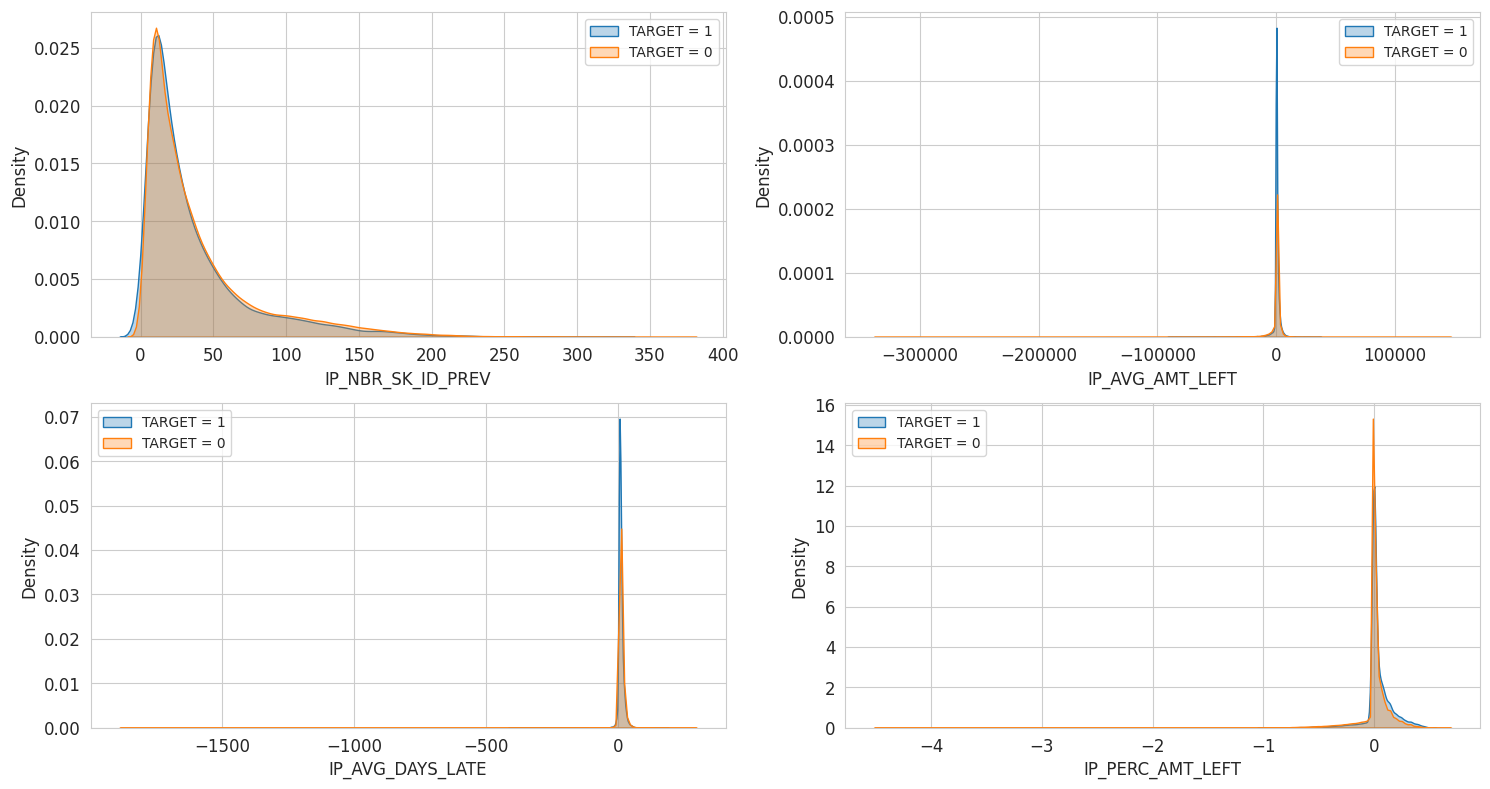

In [12]:
# Analyze relationship with TARGET
installments_vars = [
    'IP_NBR_SK_ID_PREV',
    'IP_AVG_AMT_LEFT',
    'IP_AVG_DAYS_LATE',
    'IP_PERC_AMT_LEFT'
]
plot_dist_TARGET(installments_merged, installments_vars, num_rows=2)

## 2.2. Dataframe  `POS_CASH_balance`

<b>Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit

In [13]:
key = 'POS_CASH_balance'
print(f'Dataframe {key} includes {len(data[key].columns)} features and {data[key].count()} observations.')
data[key].printSchema()

Dataframe POS_CASH_balance includes 8 features and 10001358 observations.
root
 |-- SK_ID_PREV: integer (nullable = true)
 |-- SK_ID_CURR: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- CNT_INSTALMENT: double (nullable = true)
 |-- CNT_INSTALMENT_FUTURE: double (nullable = true)
 |-- NAME_CONTRACT_STATUS: string (nullable = true)
 |-- SK_DPD: integer (nullable = true)
 |-- SK_DPD_DEF: integer (nullable = true)



In [14]:
# Analyze contract status distribution
pos_df = data[key]
pos_df.groupBy("NAME_CONTRACT_STATUS").count()\
    .withColumn('percent', F.round(col('count')*100/pos_df.count(), 2))\
    .show()

+--------------------+-------+-------+
|NAME_CONTRACT_STATUS|  count|percent|
+--------------------+-------+-------+
|              Demand|   7065|   0.07|
|              Signed|  87260|   0.87|
|              Active|9151119|   91.5|
|            Approved|   4917|   0.05|
|           Completed| 744883|   7.45|
|Returned to the s...|   5461|   0.05|
|                 XNA|      2|    0.0|
|            Canceled|     15|    0.0|
|      Amortized debt|    636|   0.01|
+--------------------+-------+-------+



In [15]:
# Aggregate by current application ID
pos_agg = pos_df.groupBy(['SK_ID_CURR']).agg(
    F.count(col('SK_ID_PREV')).alias('NBR_SK_ID_PREV'),
    avg(col('CNT_INSTALMENT_FUTURE')).alias('AVG_CNT_INSTALMENT_FUTURE'),
    avg(col('SK_DPD_DEF')).alias('AVG_SK_DPD_DEF'),
    (F.sum(col('CNT_INSTALMENT_FUTURE'))/F.sum(col('CNT_INSTALMENT'))).alias('PERC_CNT_LEFT')
)

# Add prefix to column names for joining
pos_prefixed = pos_agg.select([F.col(c).alias(f"POS_{c}") for c in pos_agg.columns])

# Join with application_train
pos_merged = data['application_train'].join(
    pos_prefixed,
    data['application_train'].SK_ID_CURR == pos_prefixed.POS_SK_ID_CURR,
    how='inner'
)

Correlation between POS_NBR_SK_ID_PREV and TARGET: -0.0356
Median value for default loans: 19.0000
Median value for non-default loans: 23.0000


Correlation between POS_AVG_CNT_INSTALMENT_FUTURE and TARGET: 0.0278
Median value for default loans: 7.2000
Median value for non-default loans: 6.9211


Correlation between POS_AVG_SK_DPD_DEF and TARGET: 0.0065
Median value for default loans: 0.0000
Median value for non-default loans: 0.0000


Correlation between POS_PERC_CNT_LEFT and TARGET: 0.0308
Median value for default loans: 0.5833
Median value for non-default loans: 0.5690




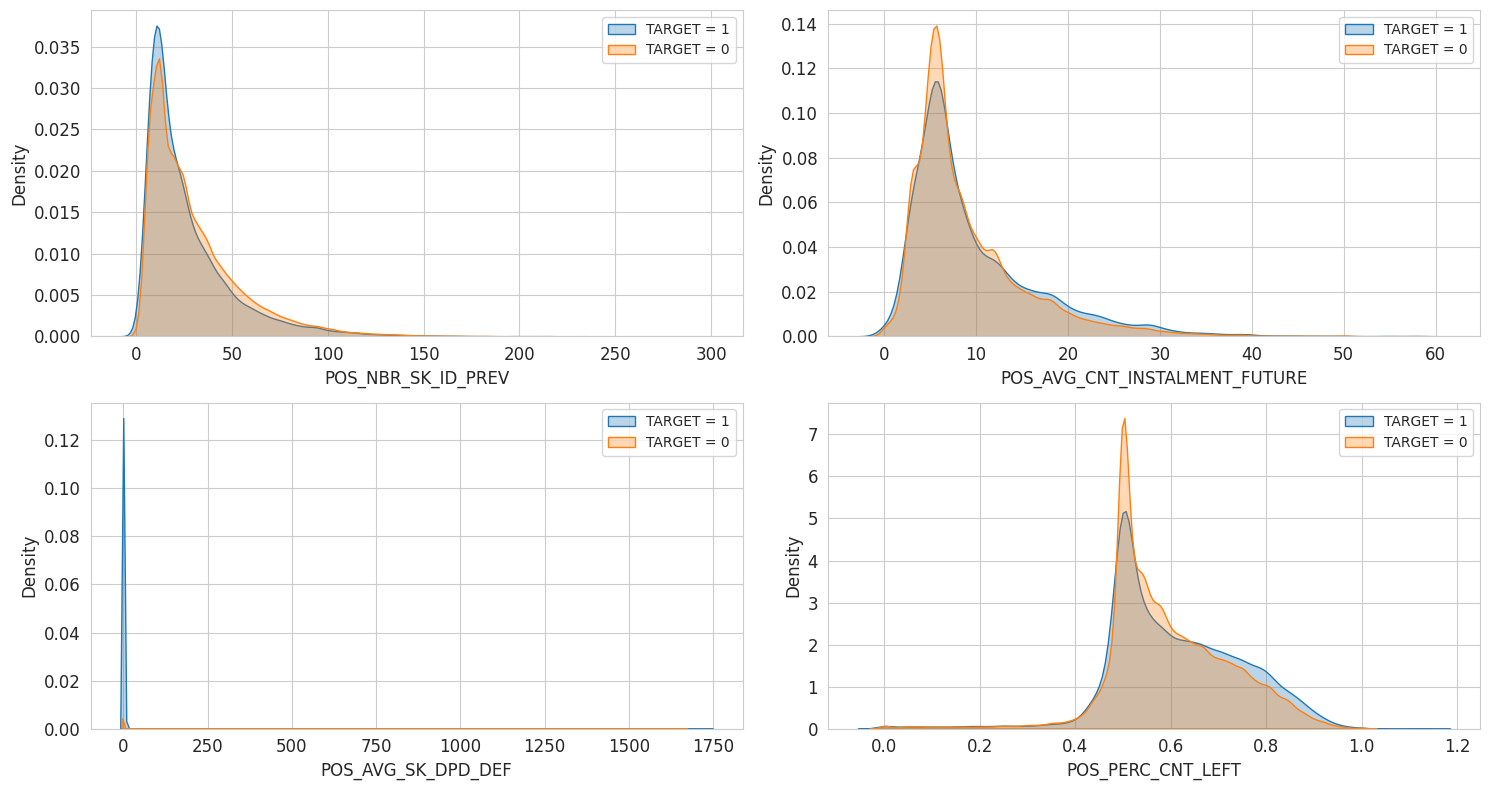

In [16]:
# Analyze relationship with TARGET
pos_vars = [
    'POS_NBR_SK_ID_PREV',
    'POS_AVG_CNT_INSTALMENT_FUTURE',
    'POS_AVG_SK_DPD_DEF',
    'POS_PERC_CNT_LEFT'
]
plot_dist_TARGET(pos_merged, pos_vars, num_rows=2)

## 2.3. Dataframe `credit_card_balance`

In [17]:
key = 'credit_card_balance'
print(f'Dataframe {key} includes {len(data[key].columns)} features and {data[key].count()} observations.')
data[key].printSchema()

Dataframe credit_card_balance includes 23 features and 3840312 observations.
root
 |-- SK_ID_PREV: integer (nullable = true)
 |-- SK_ID_CURR: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- AMT_BALANCE: double (nullable = true)
 |-- AMT_CREDIT_LIMIT_ACTUAL: integer (nullable = true)
 |-- AMT_DRAWINGS_ATM_CURRENT: double (nullable = true)
 |-- AMT_DRAWINGS_CURRENT: double (nullable = true)
 |-- AMT_DRAWINGS_OTHER_CURRENT: double (nullable = true)
 |-- AMT_DRAWINGS_POS_CURRENT: double (nullable = true)
 |-- AMT_INST_MIN_REGULARITY: double (nullable = true)
 |-- AMT_PAYMENT_CURRENT: double (nullable = true)
 |-- AMT_PAYMENT_TOTAL_CURRENT: double (nullable = true)
 |-- AMT_RECEIVABLE_PRINCIPAL: double (nullable = true)
 |-- AMT_RECIVABLE: double (nullable = true)
 |-- AMT_TOTAL_RECEIVABLE: double (nullable = true)
 |-- CNT_DRAWINGS_ATM_CURRENT: double (nullable = true)
 |-- CNT_DRAWINGS_CURRENT: integer (nullable = true)
 |-- CNT_DRAWINGS_OTHER_CURRENT: double

In [18]:
# Analyze contract status distribution
cc_df = data[key]
cc_df.groupBy("NAME_CONTRACT_STATUS").count()\
    .withColumn('percent', F.round(col('count')*100/cc_df.count(), 2))\
    .show()

+--------------------+-------+-------+
|NAME_CONTRACT_STATUS|  count|percent|
+--------------------+-------+-------+
|              Demand|   1365|   0.04|
|       Sent proposal|    513|   0.01|
|              Signed|  11058|   0.29|
|             Refused|     17|    0.0|
|              Active|3698436|  96.31|
|           Completed| 128918|   3.36|
|            Approved|      5|    0.0|
+--------------------+-------+-------+



In [19]:
# Aggregate by current application ID
cc_agg = cc_df.groupBy(['SK_ID_CURR']).agg(
    F.count(col('SK_ID_PREV')).alias('NBR_SK_ID_PREV'),
    avg(col('AMT_PAYMENT_TOTAL_CURRENT')).alias('AVG_AMT_PAYMENT_TOTAL'),
    avg(col('AMT_TOTAL_RECEIVABLE')).alias('AVG_SK_DPD_DEF'),
    F.sum(col('CNT_INSTALMENT_MATURE_CUM')).alias('SUM_CNT_INSTALMENT_MATURE')
)

# Add prefix to column names for joining
cc_prefixed = cc_agg.select([F.col(c).alias(f"CR_{c}") for c in cc_agg.columns])

# Join with application_train
cc_merged = data['application_train'].join(
    cc_prefixed,
    data['application_train'].SK_ID_CURR == cc_prefixed.CR_SK_ID_CURR,
    how='inner'
)

Correlation between CR_NBR_SK_ID_PREV and TARGET: -0.0605
Median value for default loans: 16.0000
Median value for non-default loans: 22.0000


Correlation between CR_AVG_AMT_PAYMENT_TOTAL and TARGET: 0.0227
Median value for default loans: 5985.5625
Median value for non-default loans: 3906.8182


Correlation between CR_AVG_SK_DPD_DEF and TARGET: 0.0865
Median value for default loans: 61815.1001
Median value for non-default loans: 23721.9764


Correlation between CR_SUM_CNT_INSTALMENT_MATURE and TARGET: -0.0424
Median value for default loans: 45.0000
Median value for non-default loans: 52.0000




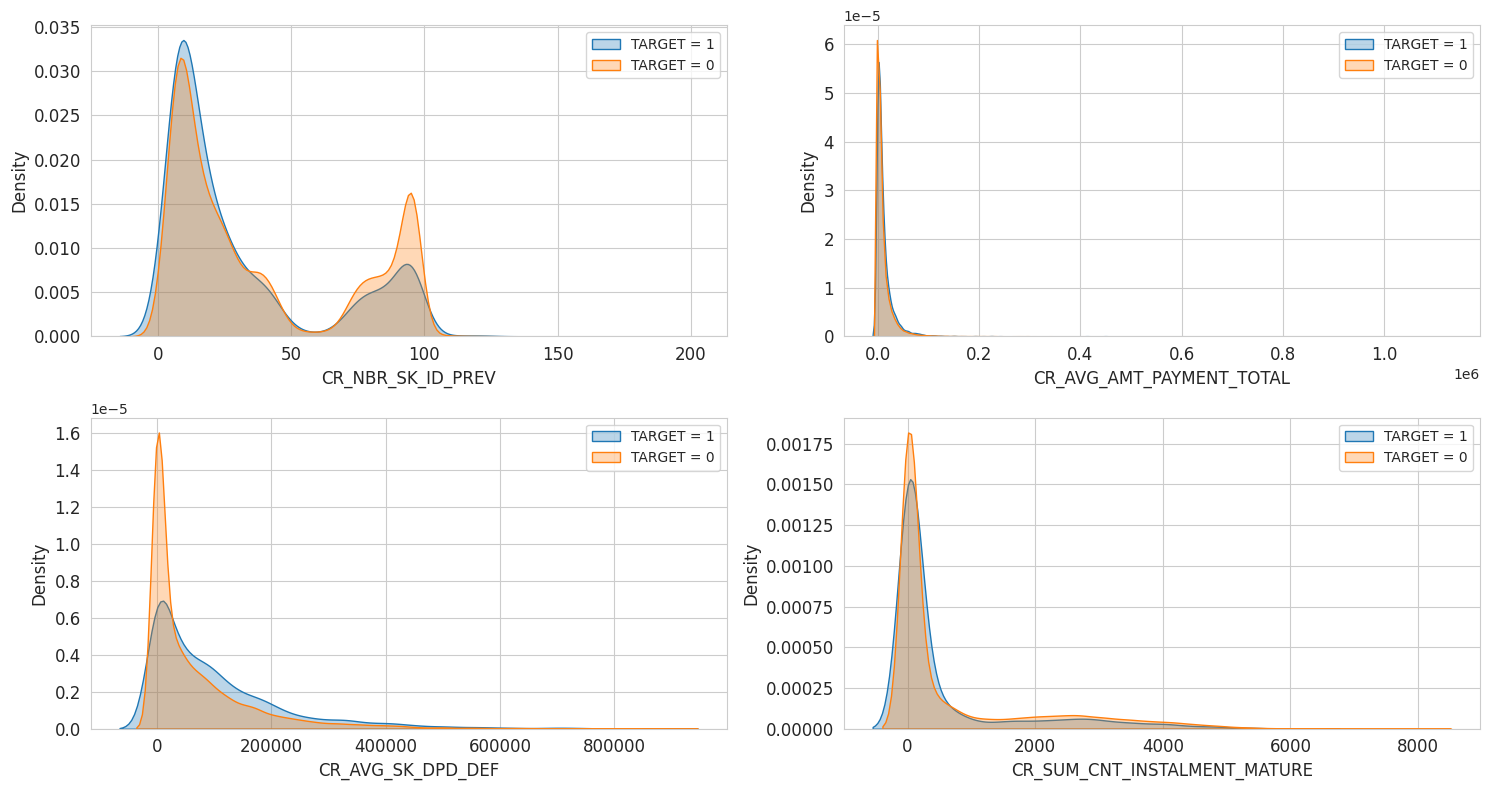

In [20]:
# Analyze relationship with TARGET
cc_vars = [
    'CR_NBR_SK_ID_PREV',
    'CR_AVG_AMT_PAYMENT_TOTAL',
    'CR_AVG_SK_DPD_DEF',
    'CR_SUM_CNT_INSTALMENT_MATURE',
]
plot_dist_TARGET(cc_merged, cc_vars, num_rows=2)

## 2.4. Comment

Based on analysis of dataframes:

1. **`bureau_balance`**:
   - Contains monthly balances information from Credit Bureaus
   - Not strongly related to default rates in current applications
   - Will not be considered further

2. **`installments_payments`, `POS_CASH_balance` and `credit_card_balance`**:
   - Most applications have active status (>90%)
   - Refused/canceled applications are negligible (<1%)
   - Weak correlation with TARGET variable
   - No significant distributional differences between default/non-default groups

**Therefore, we will focus mainly on `application_train/test`, `previous_application` and `bureau`.**

# 3. EDA `application_train`

In [21]:
key = 'application_train'
print(f'Dataframe {key} includes {len(data[key].columns)} features and {data[key].count()} observations.')
data[key].printSchema()

Dataframe application_train includes 122 features and 307511 observations.
root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nulla

## 3.1. Label `TARGET`

In [22]:
# Calculate age in years and employment duration
app_df = data[key]
app_df = app_df.withColumn('AGE_BIRTH', col('DAYS_BIRTH')/-365)
app_df = app_df.withColumn('YEARS_EMPLOYED', col('DAYS_EMPLOYED')/-365)

In [23]:
# Analyze target distribution
target_distribution = app_df.groupby('TARGET').count().toPandas()

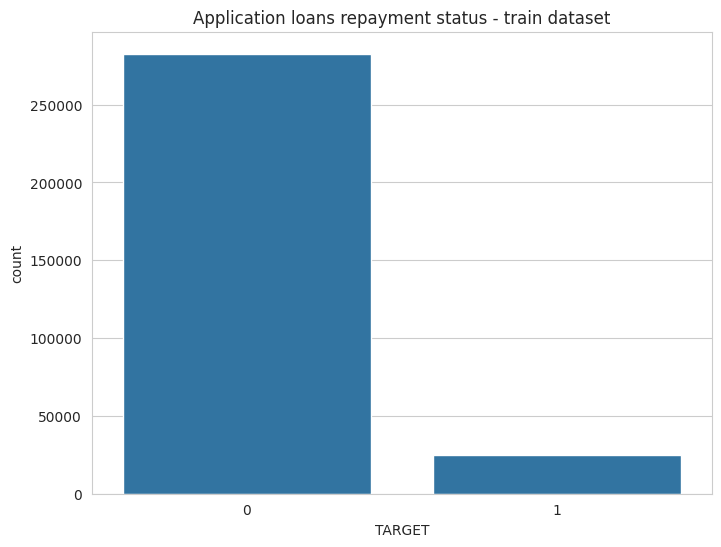

In [24]:
# Plot target distribution
plt.figure(figsize=(8, 6))
plt.title('Application loans repayment status - train dataset')
sns.set_color_codes("pastel")
sns.barplot(x='TARGET', y="count", data=target_distribution)
locs, labels = plt.xticks()
plt.show()

## 3.2. Categorical variables

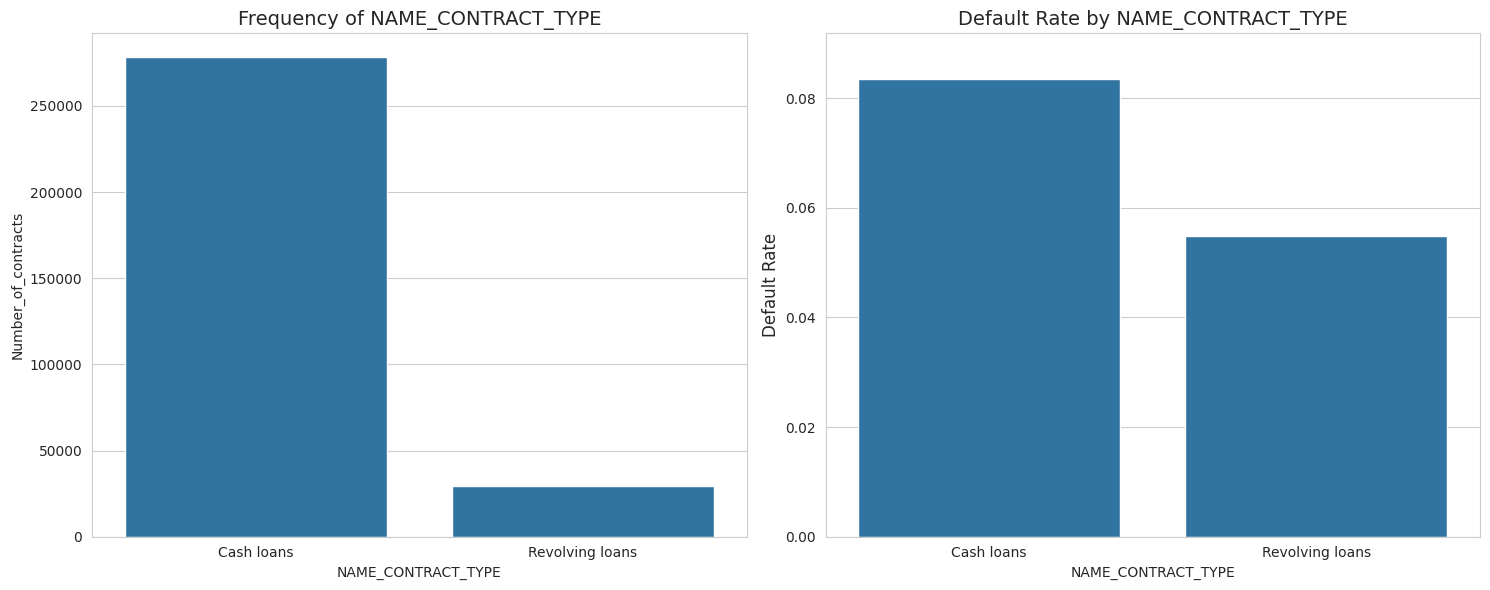

In [25]:
# Contract type
plot_freq(app_df, 'NAME_CONTRACT_TYPE')

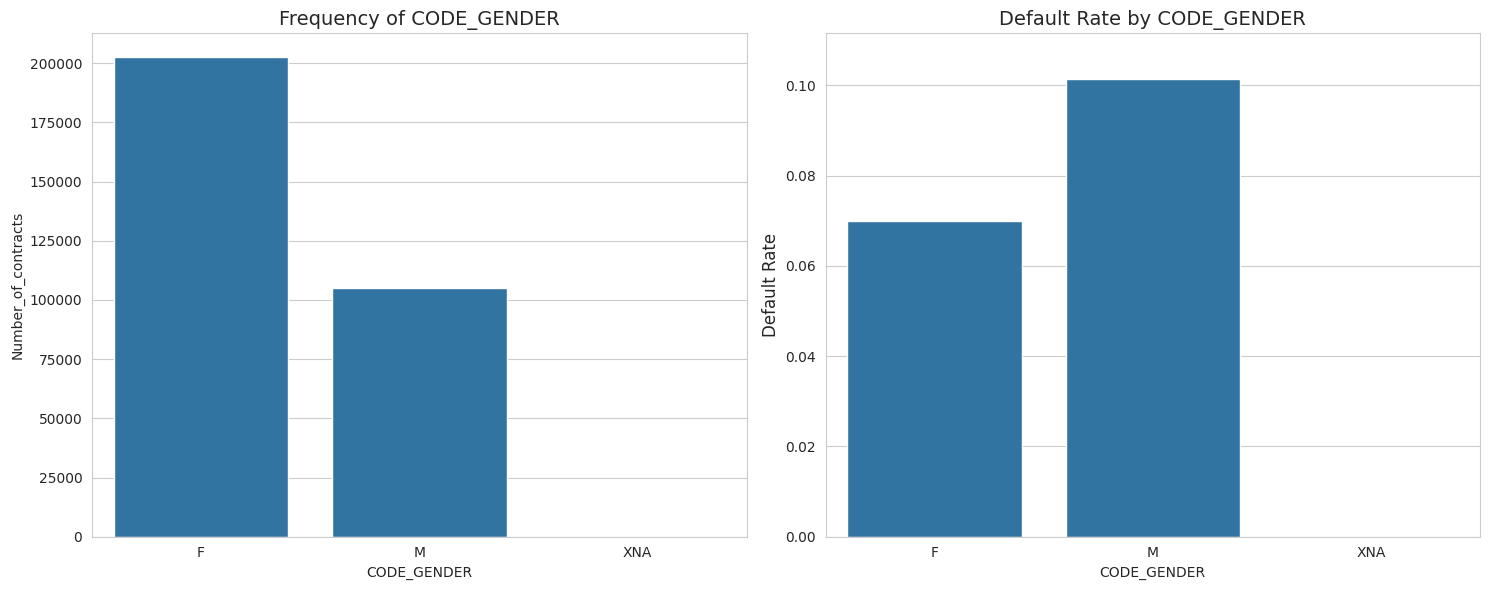

In [26]:
# Gender
plot_freq(app_df, 'CODE_GENDER')

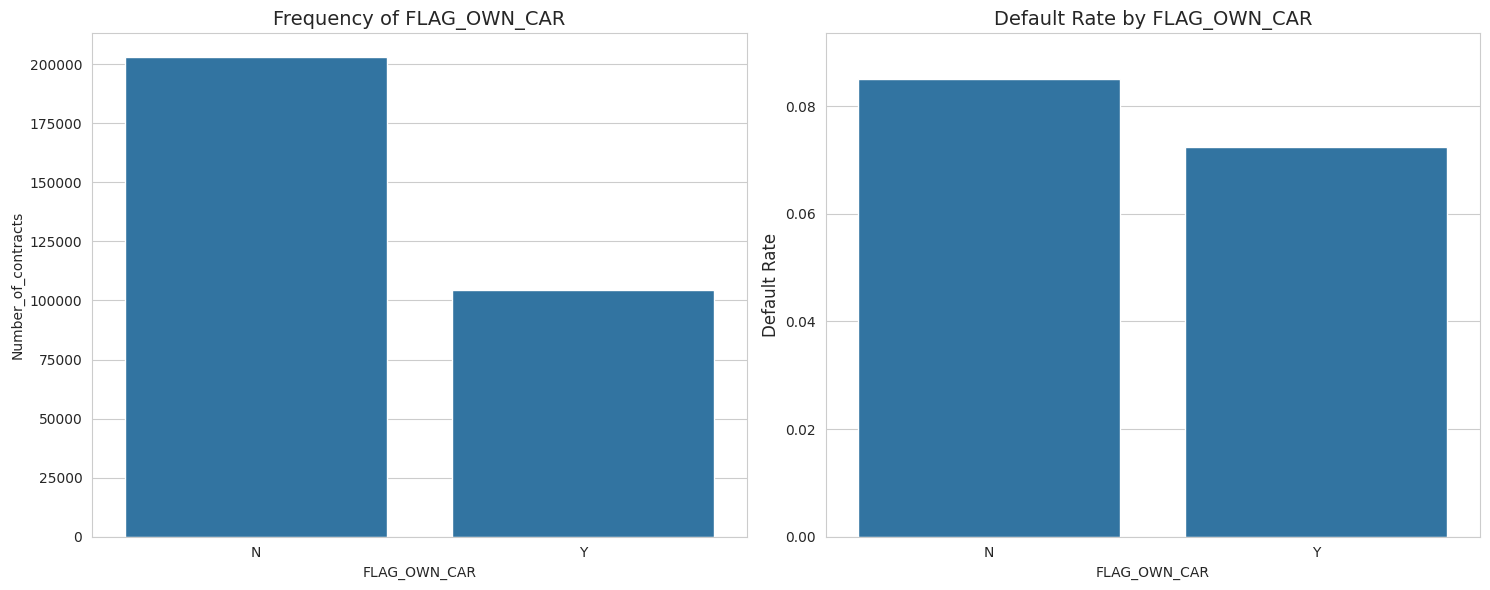

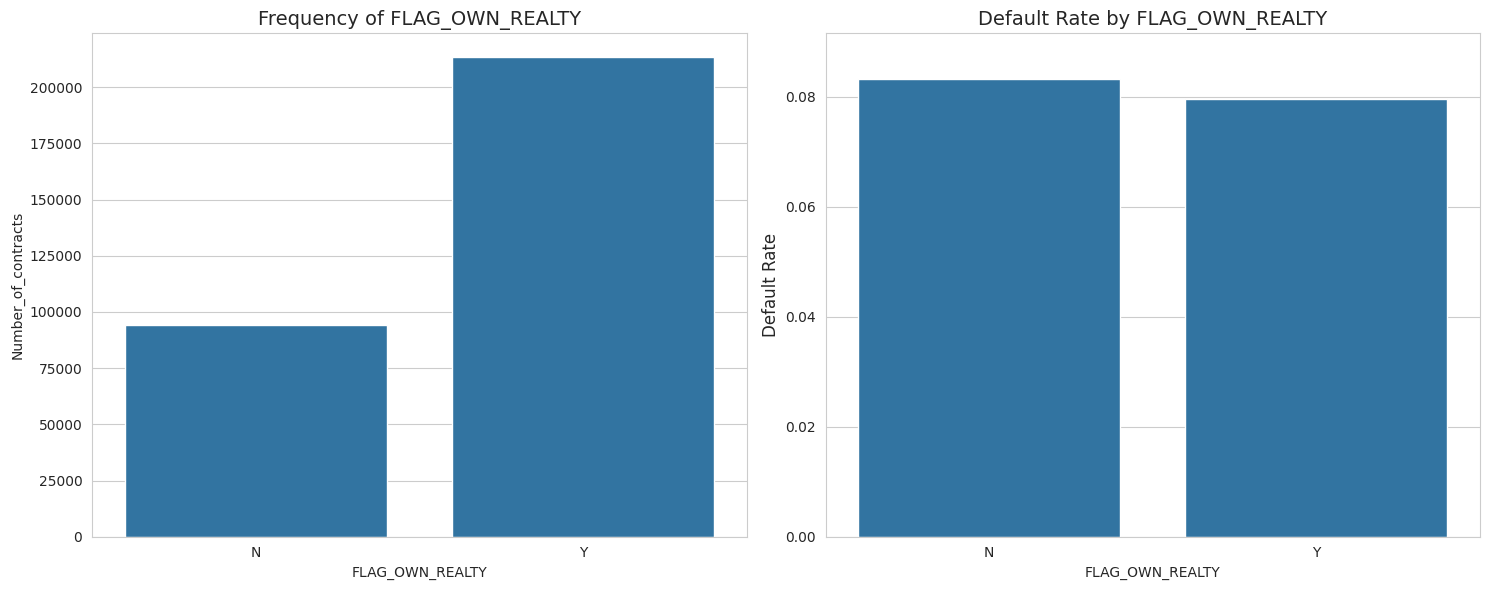

In [27]:
# Car and Property ownership
plot_freq(app_df, 'FLAG_OWN_CAR')
plot_freq(app_df, 'FLAG_OWN_REALTY')

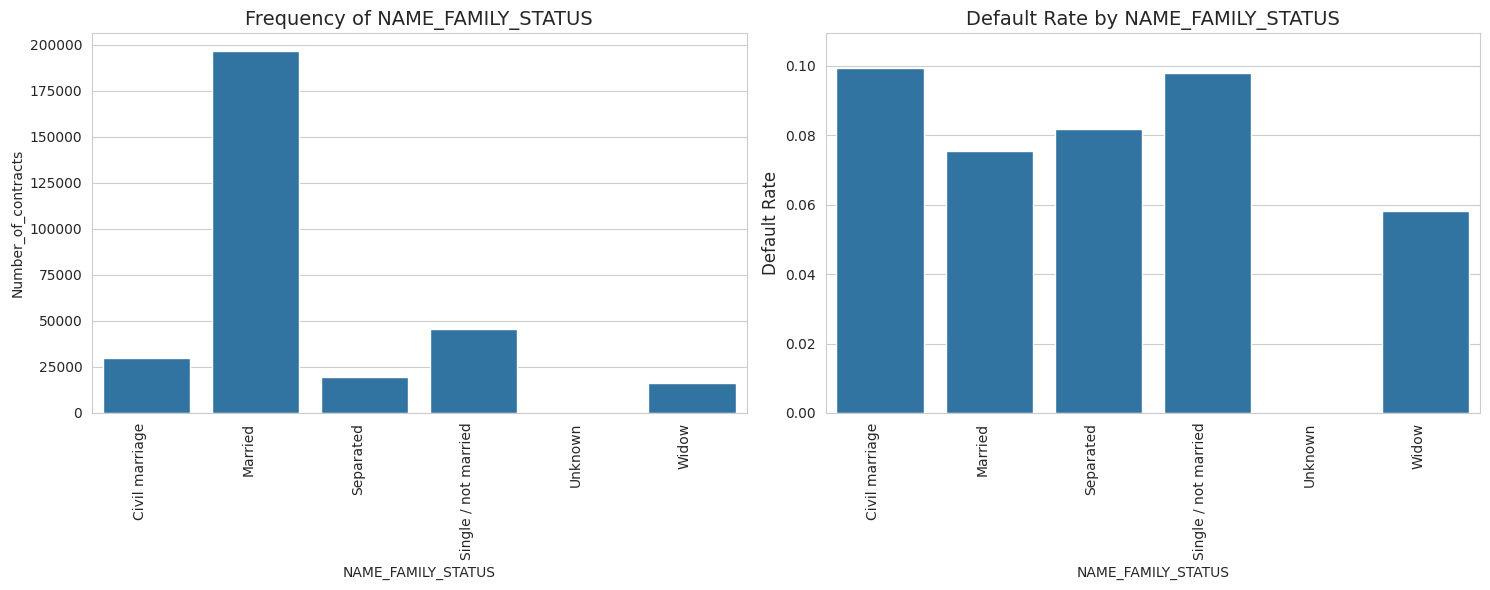

In [28]:
# Family status
plot_freq(app_df, 'NAME_FAMILY_STATUS', True, True)

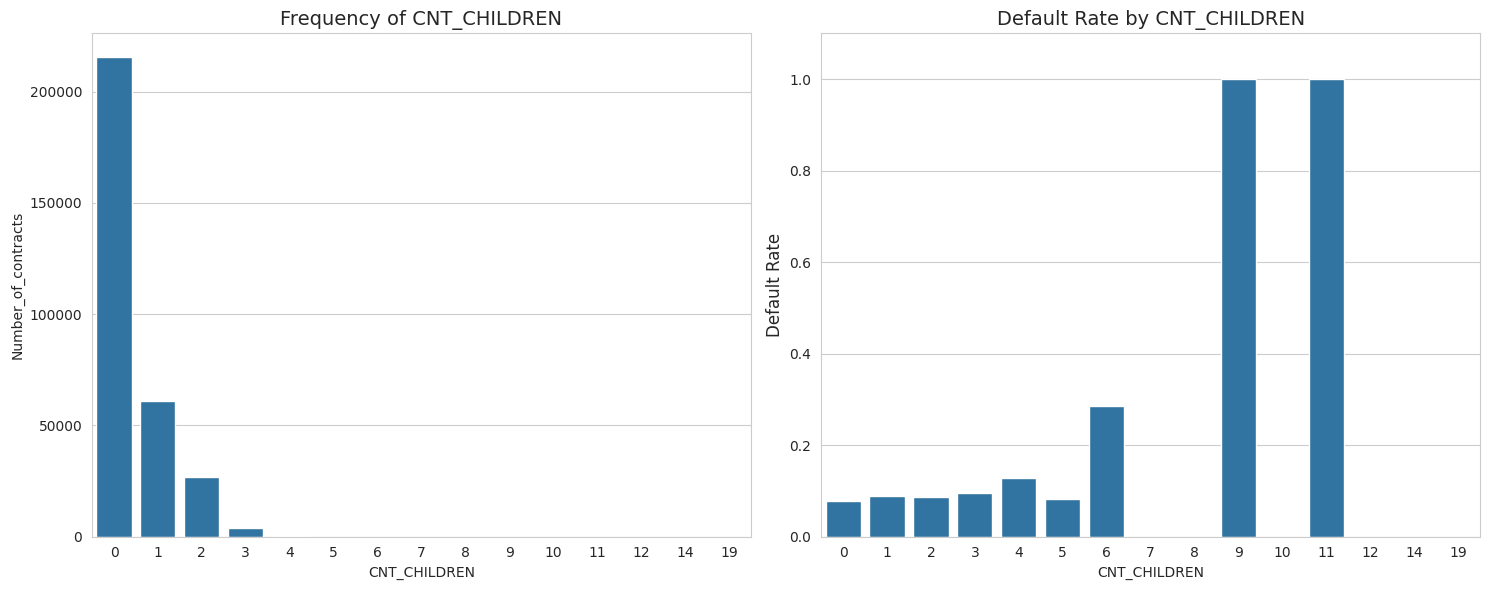

In [29]:
# Children count
plot_freq(app_df, 'CNT_CHILDREN')

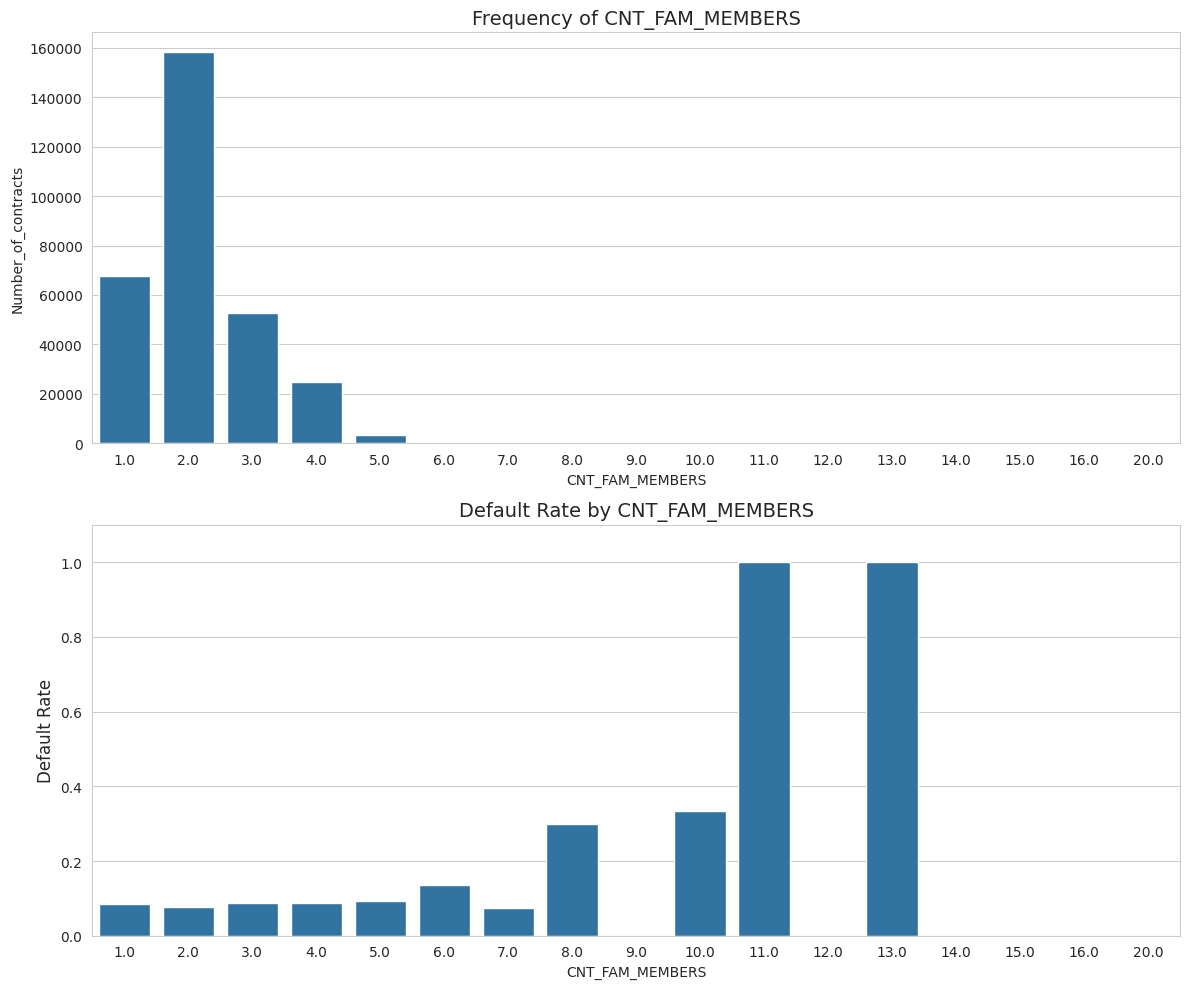

In [30]:
# Family members count
plot_freq(app_df, 'CNT_FAM_MEMBERS', False, False)

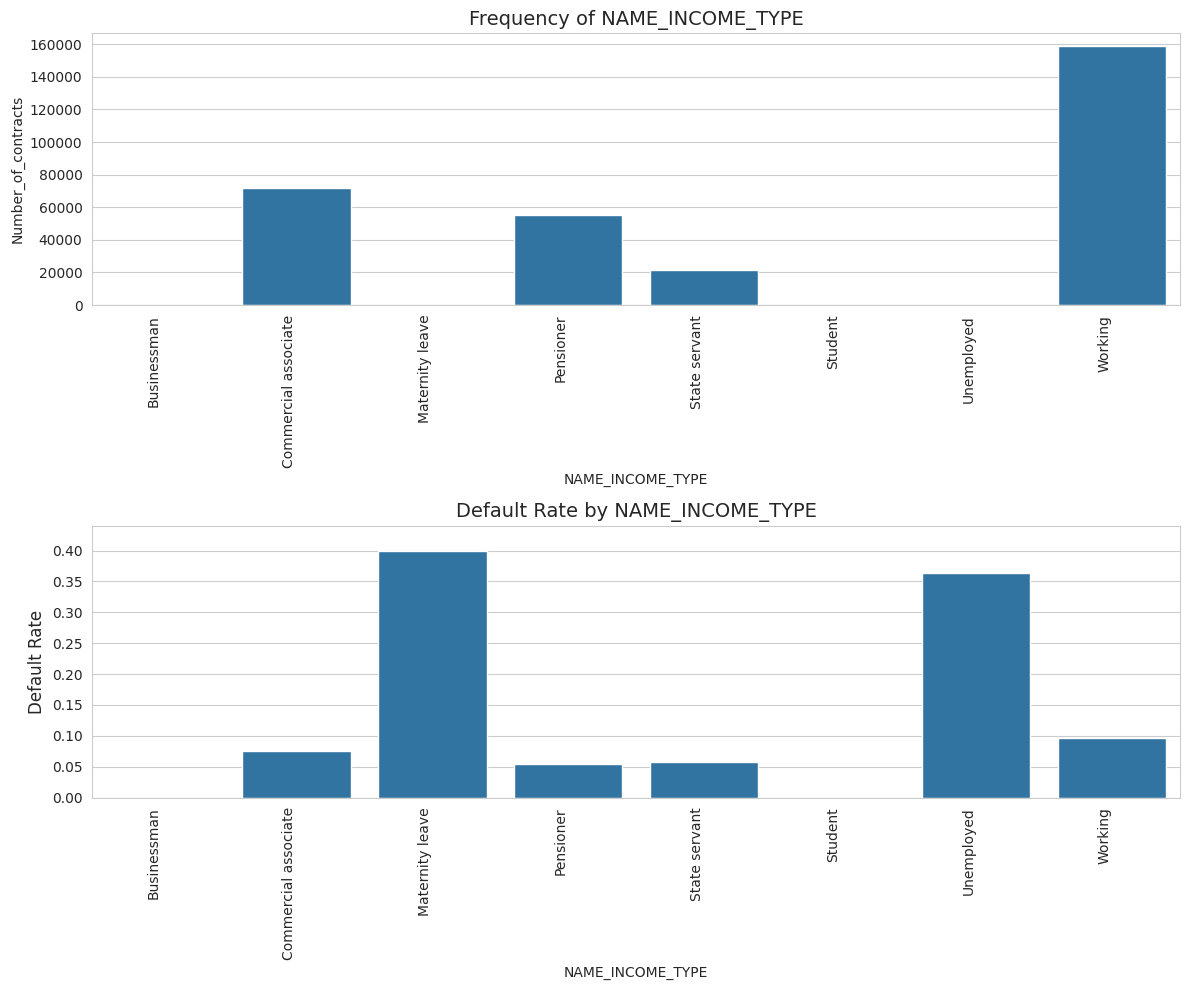

In [31]:
# Income type
plot_freq(app_df, 'NAME_INCOME_TYPE', False, True)

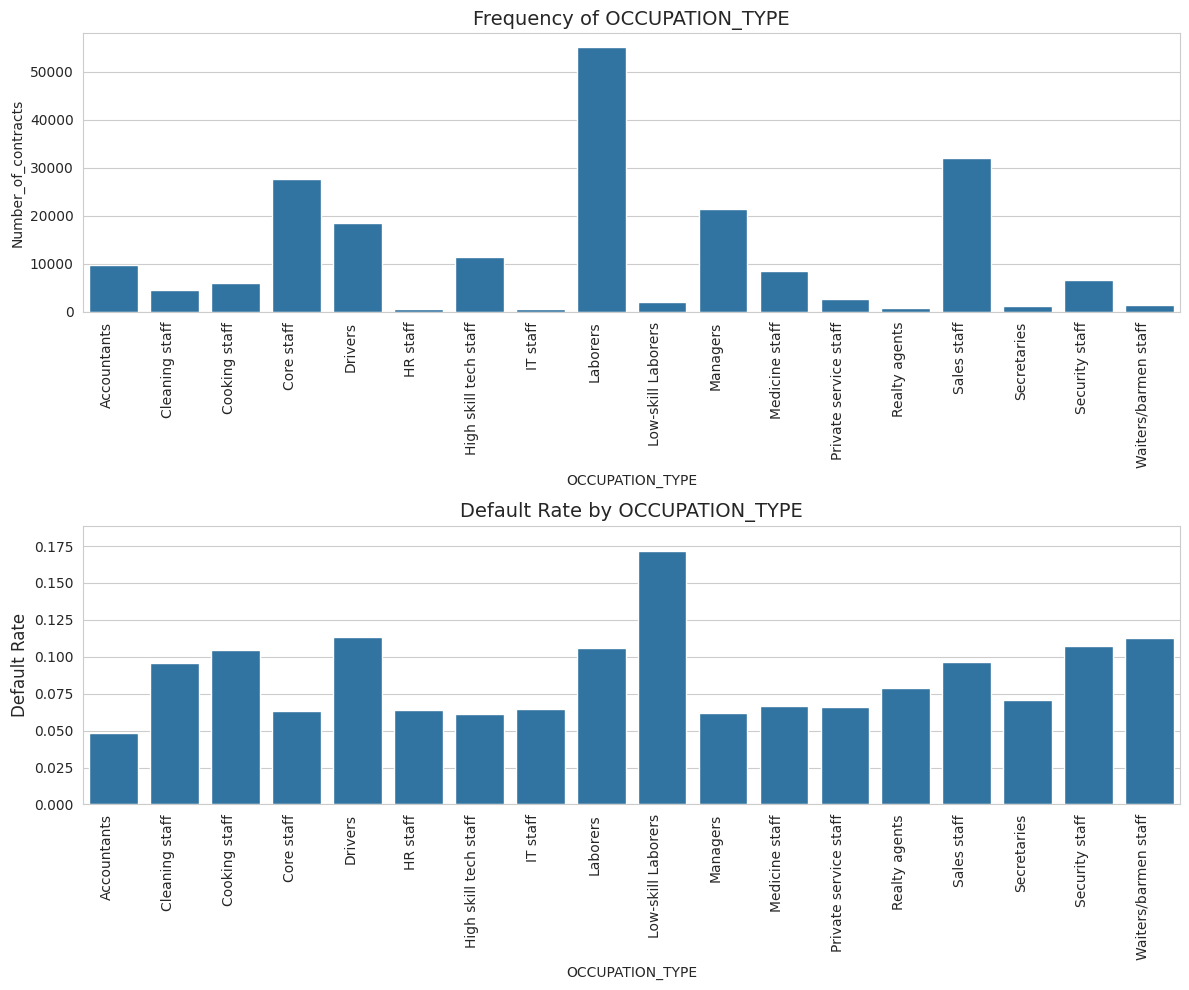

In [32]:
# Occupation type
plot_freq(app_df, 'OCCUPATION_TYPE', False, True)

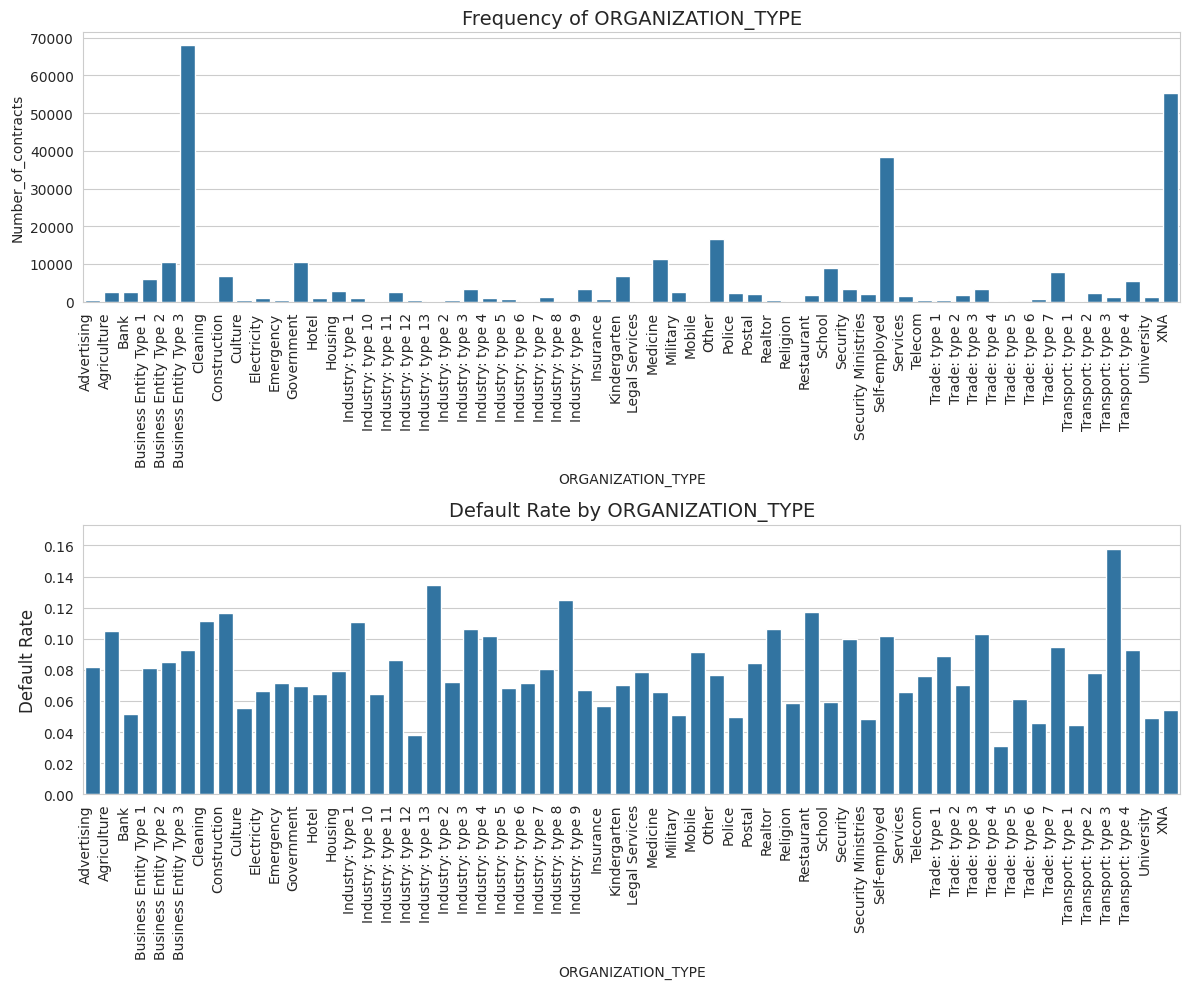

In [33]:
# Organization type
plot_freq(app_df, 'ORGANIZATION_TYPE', False, True)

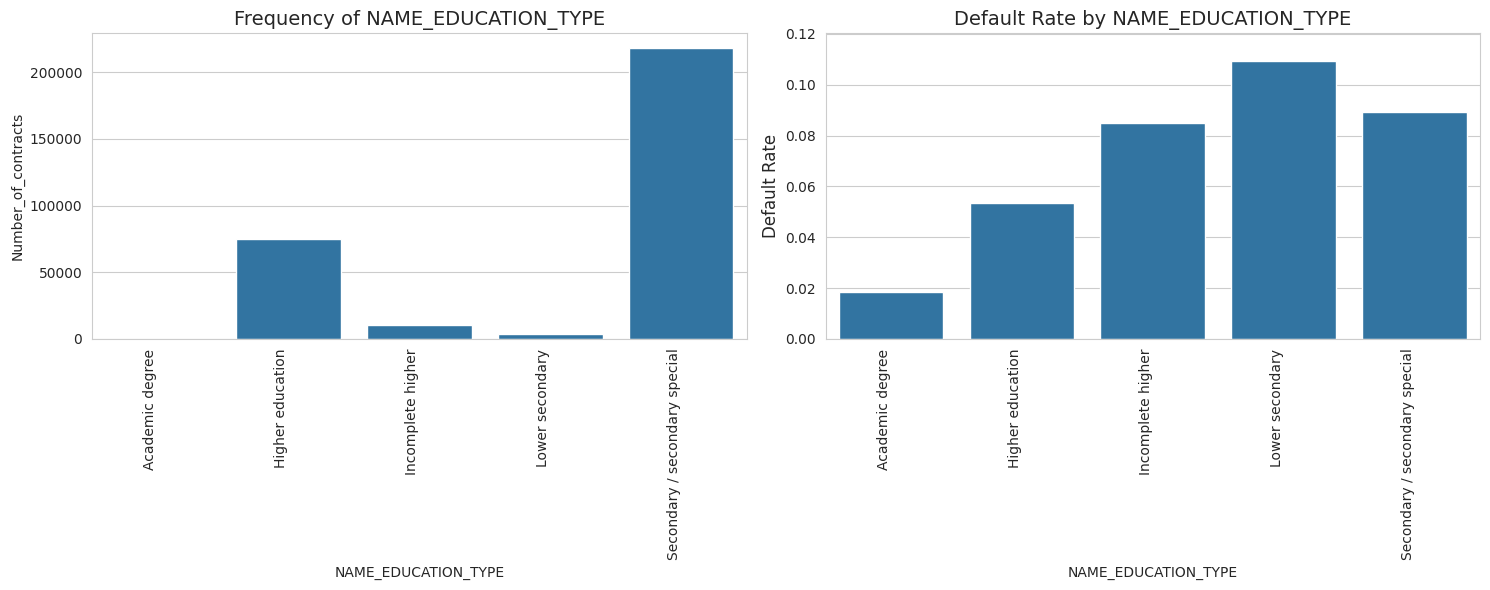

In [34]:
# Education type
plot_freq(app_df, 'NAME_EDUCATION_TYPE', True, True)

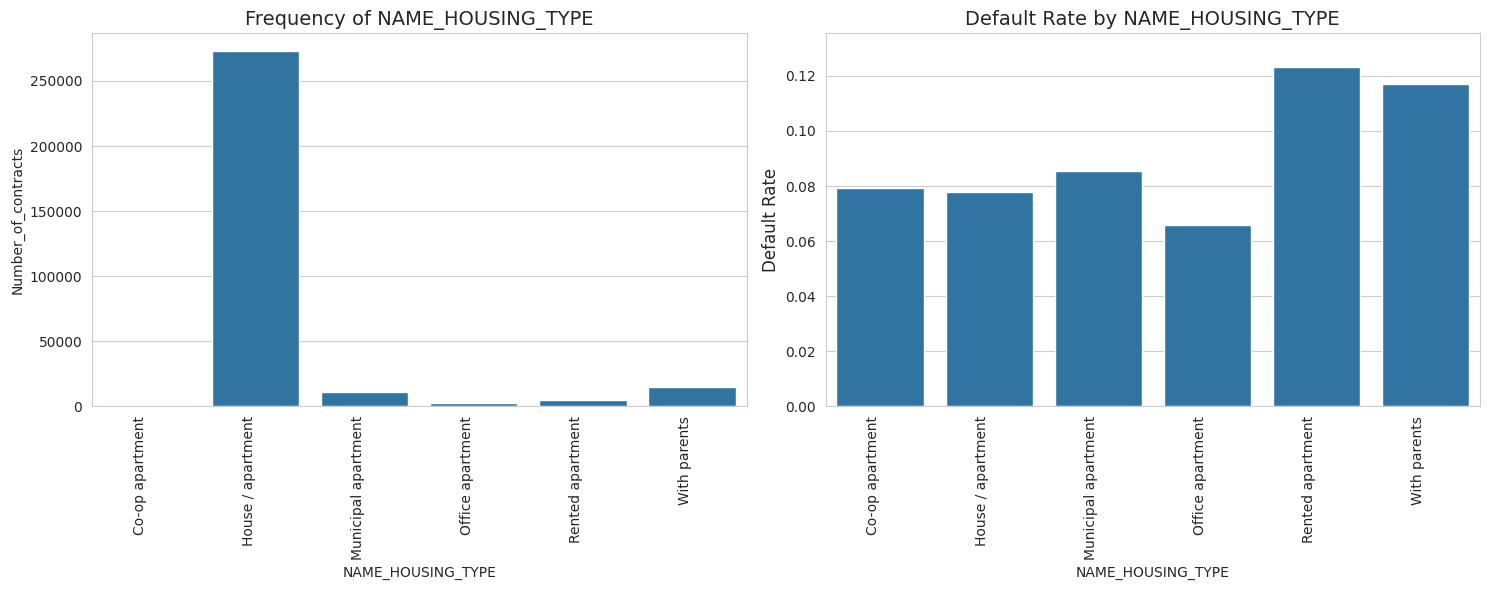

In [35]:
# Housing type
plot_freq(app_df, 'NAME_HOUSING_TYPE', True, True)

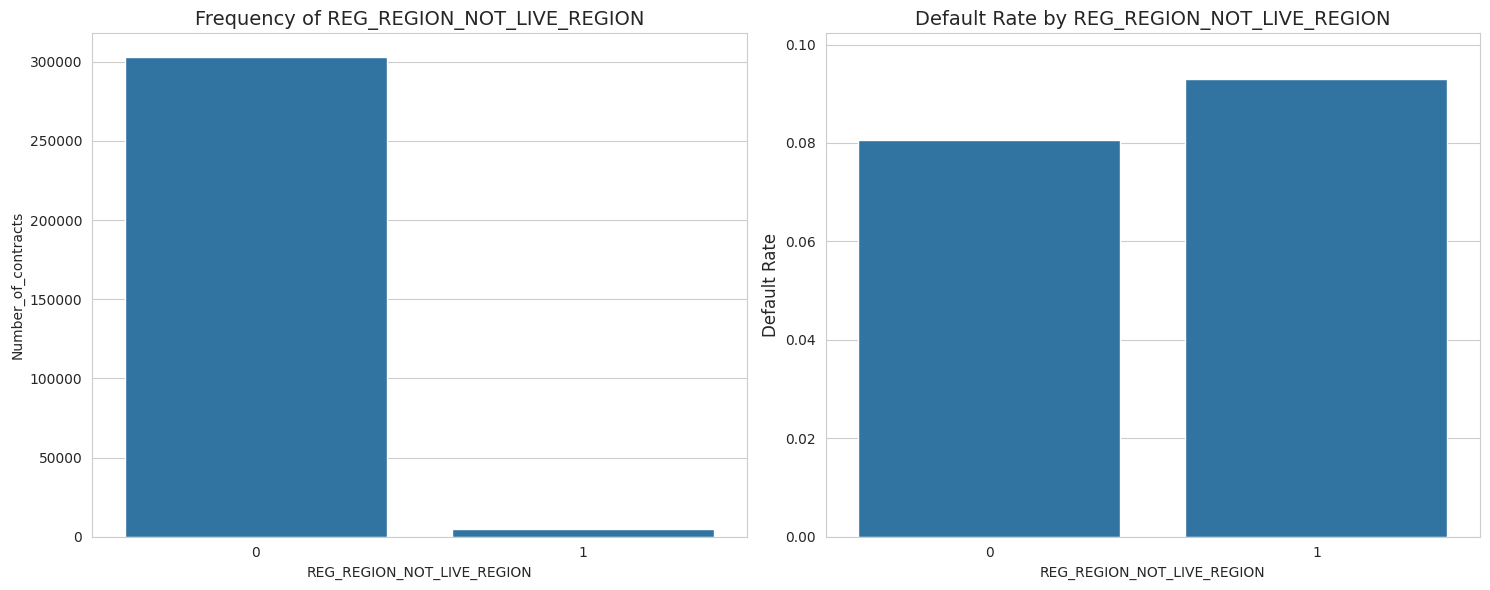

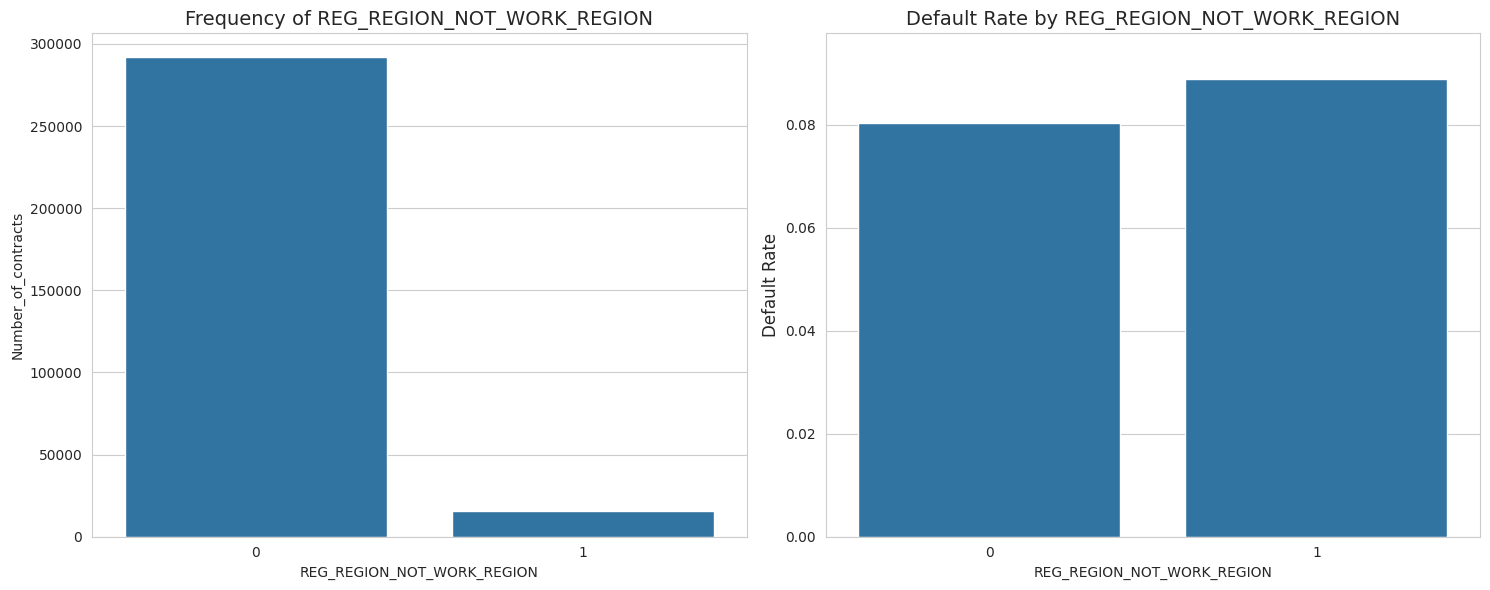

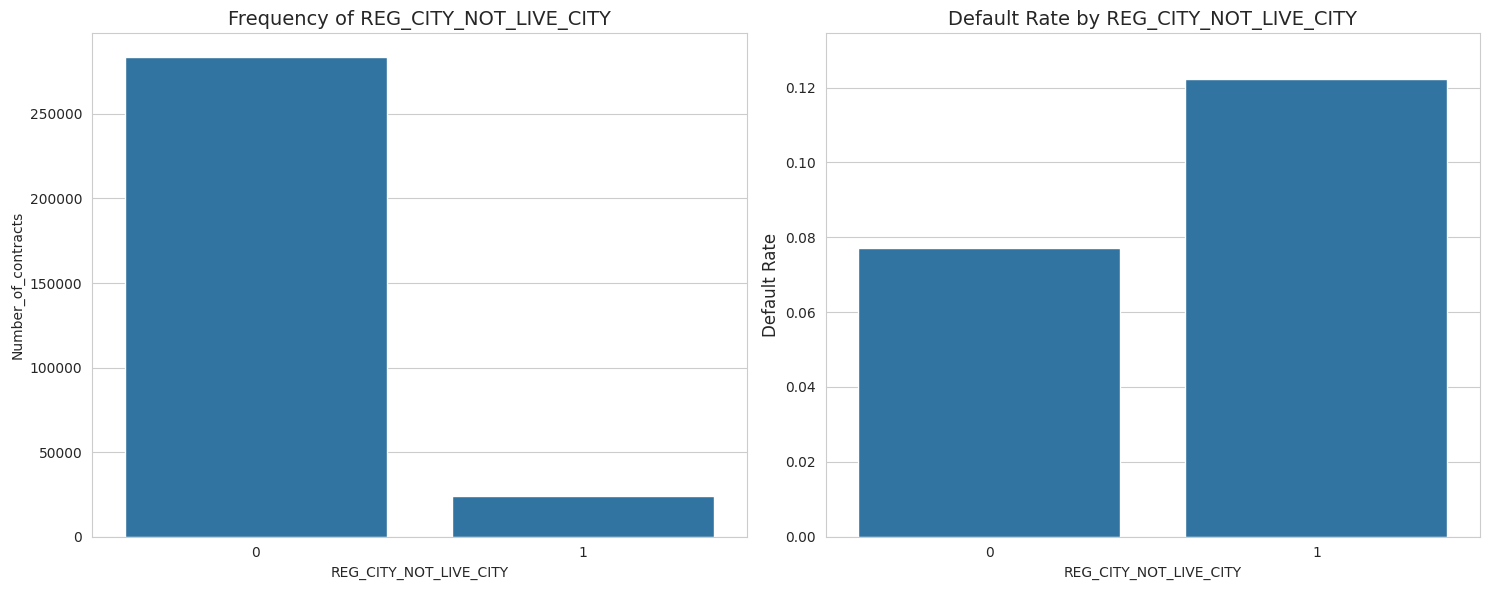

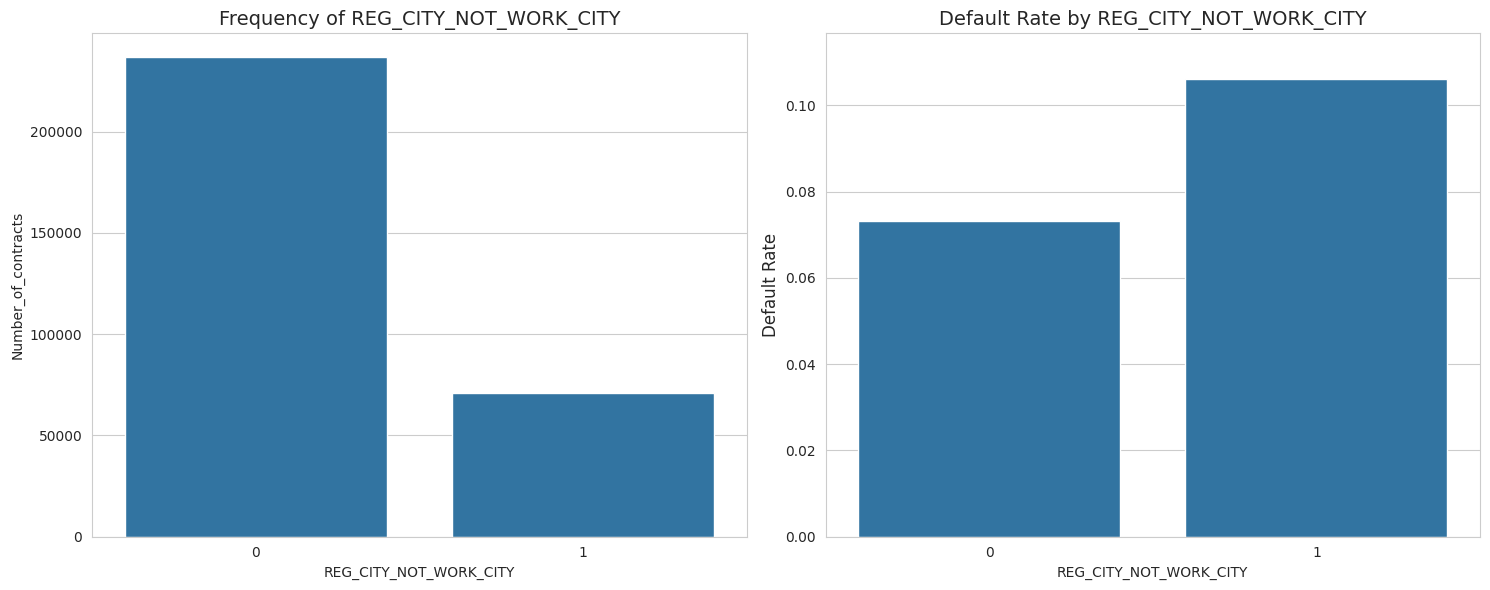

In [36]:
# Region flags
plot_freq(app_df, 'REG_REGION_NOT_LIVE_REGION')
plot_freq(app_df, 'REG_REGION_NOT_WORK_REGION')
plot_freq(app_df, 'REG_CITY_NOT_LIVE_CITY')
plot_freq(app_df, 'REG_CITY_NOT_WORK_CITY')

## 3.3. Numerical variables

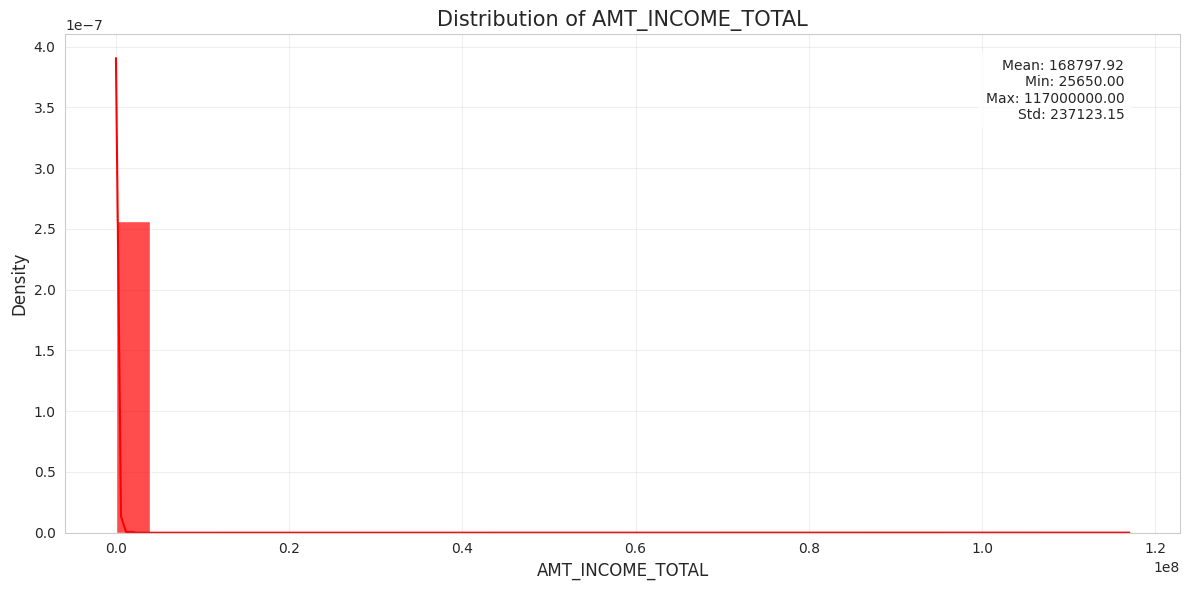

In [37]:
# Income total
plot_dist(app_df, 'AMT_INCOME_TOTAL', 'red')

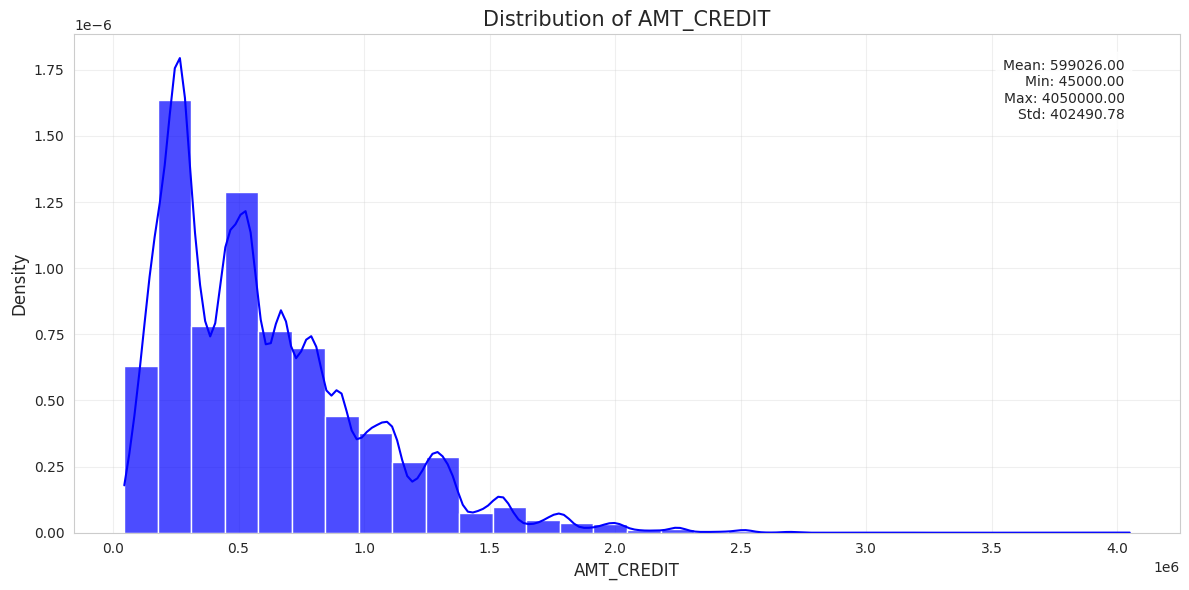

In [38]:
# Credit amount
plot_dist(app_df, 'AMT_CREDIT', 'blue')

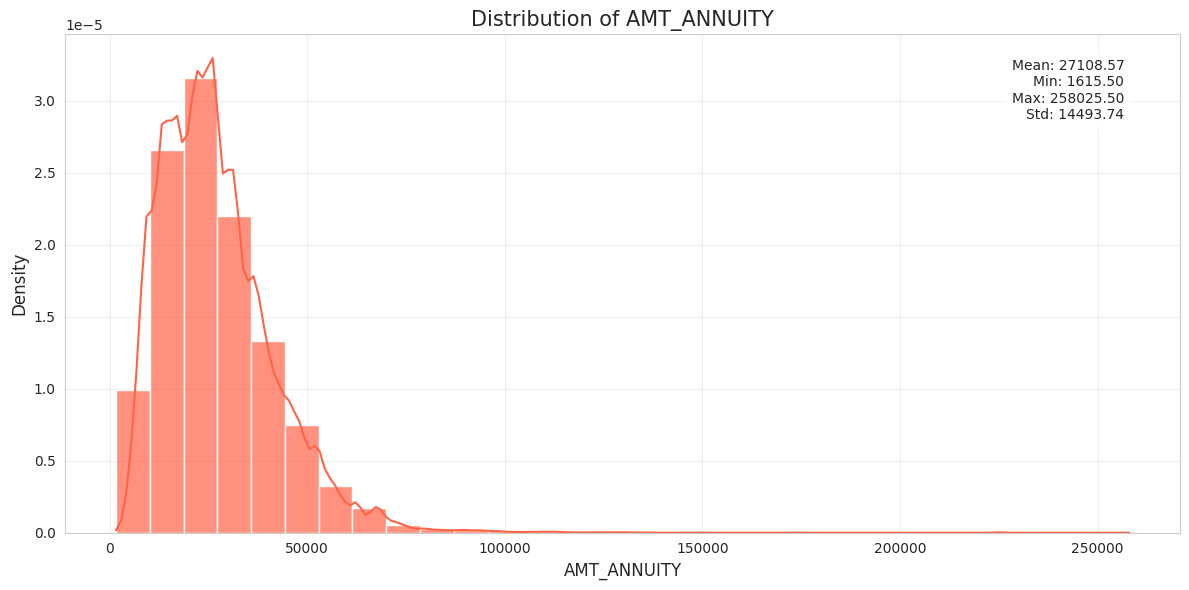

In [39]:
# Annuity amount
plot_dist(app_df, 'AMT_ANNUITY', 'tomato')

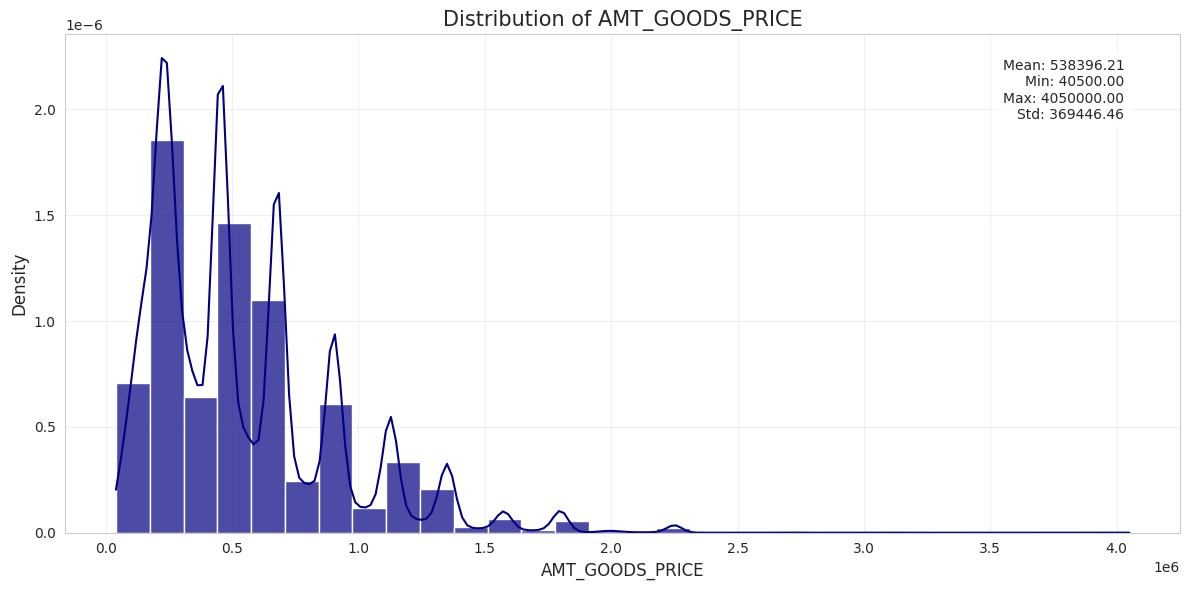

In [40]:
# Goods price
plot_dist(app_df, 'AMT_GOODS_PRICE', 'navy')

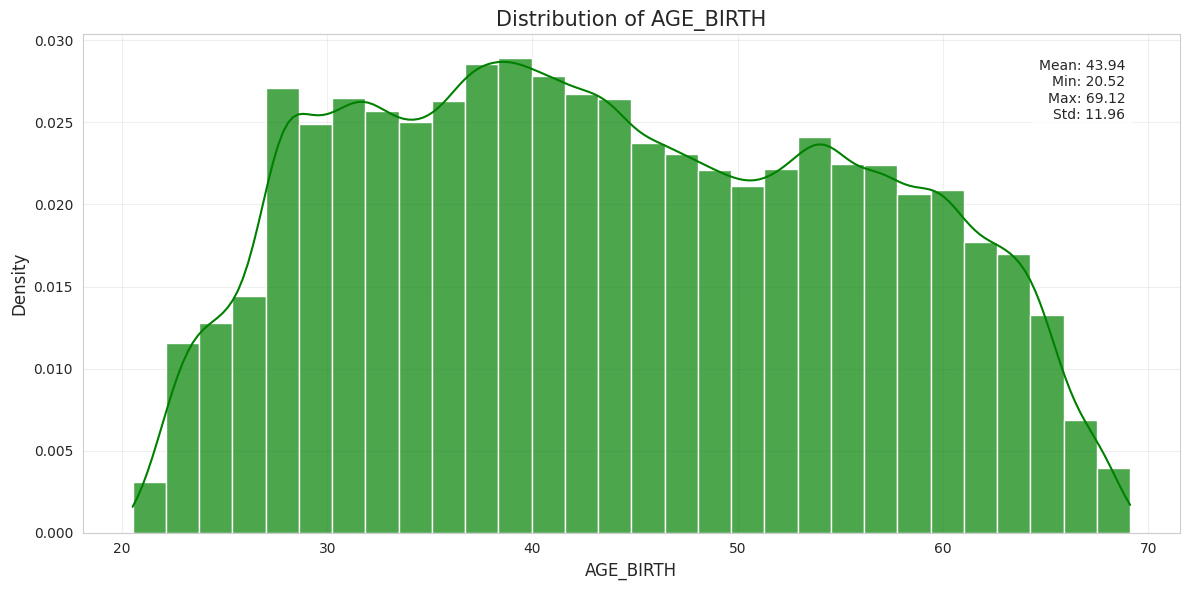

In [41]:
# Age
plot_dist(app_df, 'AGE_BIRTH', 'green')

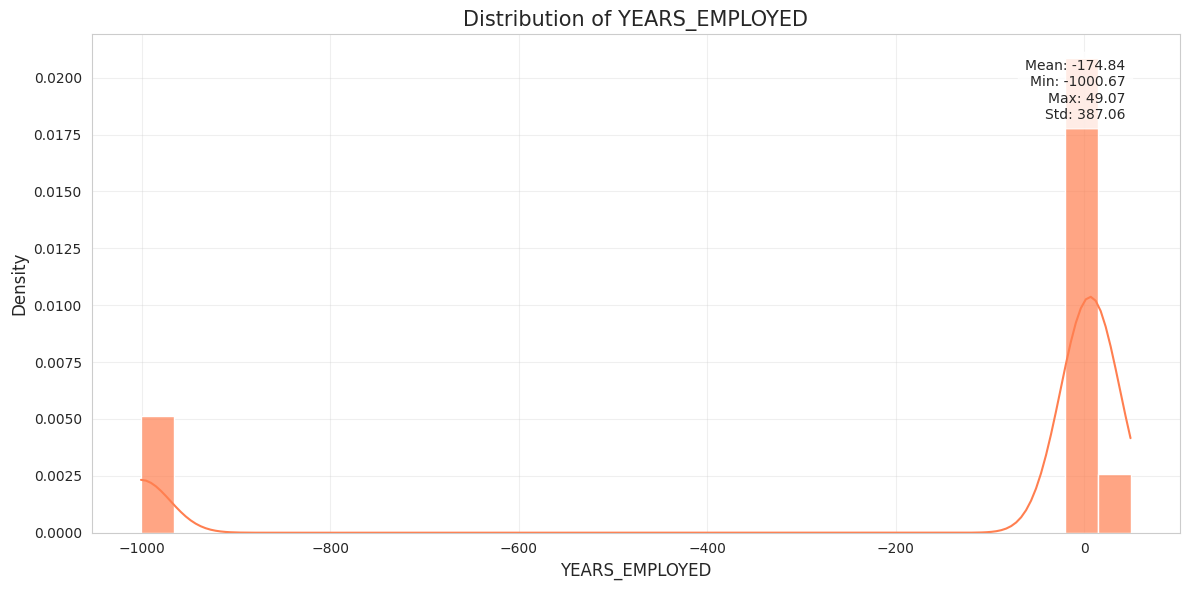

In [42]:
# Employment years
plot_dist(app_df, 'YEARS_EMPLOYED', 'coral')

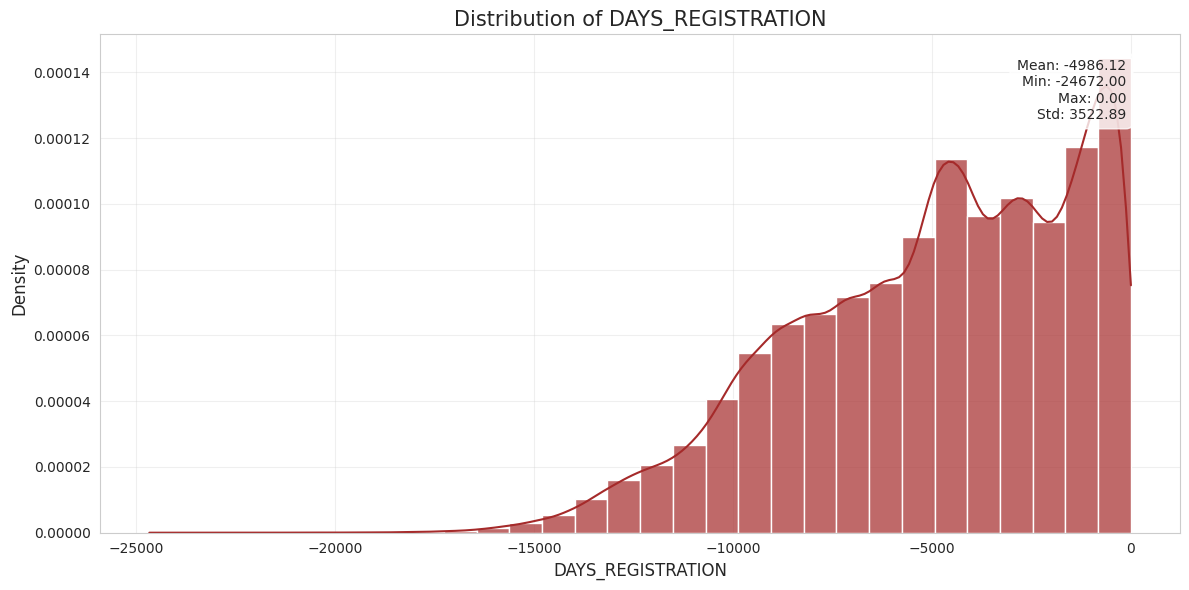

In [43]:
# Registration days
plot_dist(app_df, 'DAYS_REGISTRATION', 'brown')

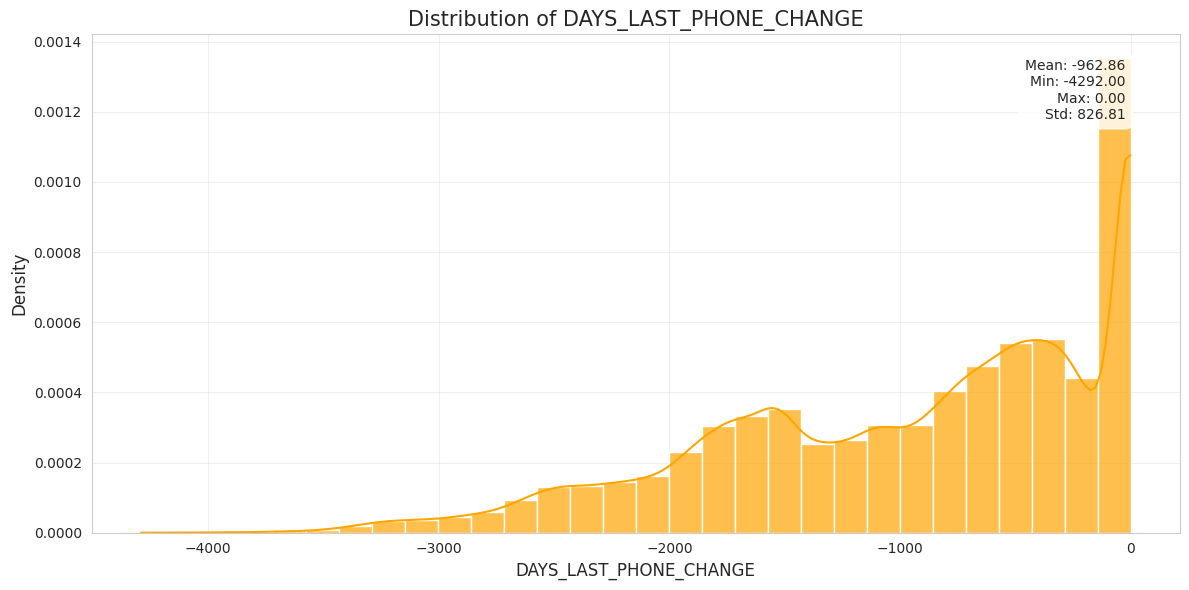

In [44]:
# Last phone change
plot_dist(app_df, 'DAYS_LAST_PHONE_CHANGE', 'orange')

Correlation between AMT_ANNUITY and TARGET: -0.0128
Median value for default loans: 25263.0000
Median value for non-default loans: 24876.0000


Correlation between AMT_CREDIT and TARGET: -0.0304
Median value for default loans: 497520.0000
Median value for non-default loans: 517788.0000


Correlation between AMT_GOODS_PRICE and TARGET: -0.0396
Median value for default loans: 450000.0000
Median value for non-default loans: 450000.0000


Correlation between YEARS_EMPLOYED and TARGET: 0.0449
Median value for default loans: 2.8329
Median value for non-default loans: 3.3836


Correlation between DAYS_REGISTRATION and TARGET: 0.0420
Median value for default loans: -4056.0000
Median value for non-default loans: -4544.0000


Correlation between AGE_BIRTH and TARGET: -0.0782
Median value for default loans: 39.1288
Median value for non-default loans: 43.4986


Correlation between EXT_SOURCE_1 and TARGET: -0.0647
Median value for default loans: 0.0000
Median value for non-default loans: 0.0000


C

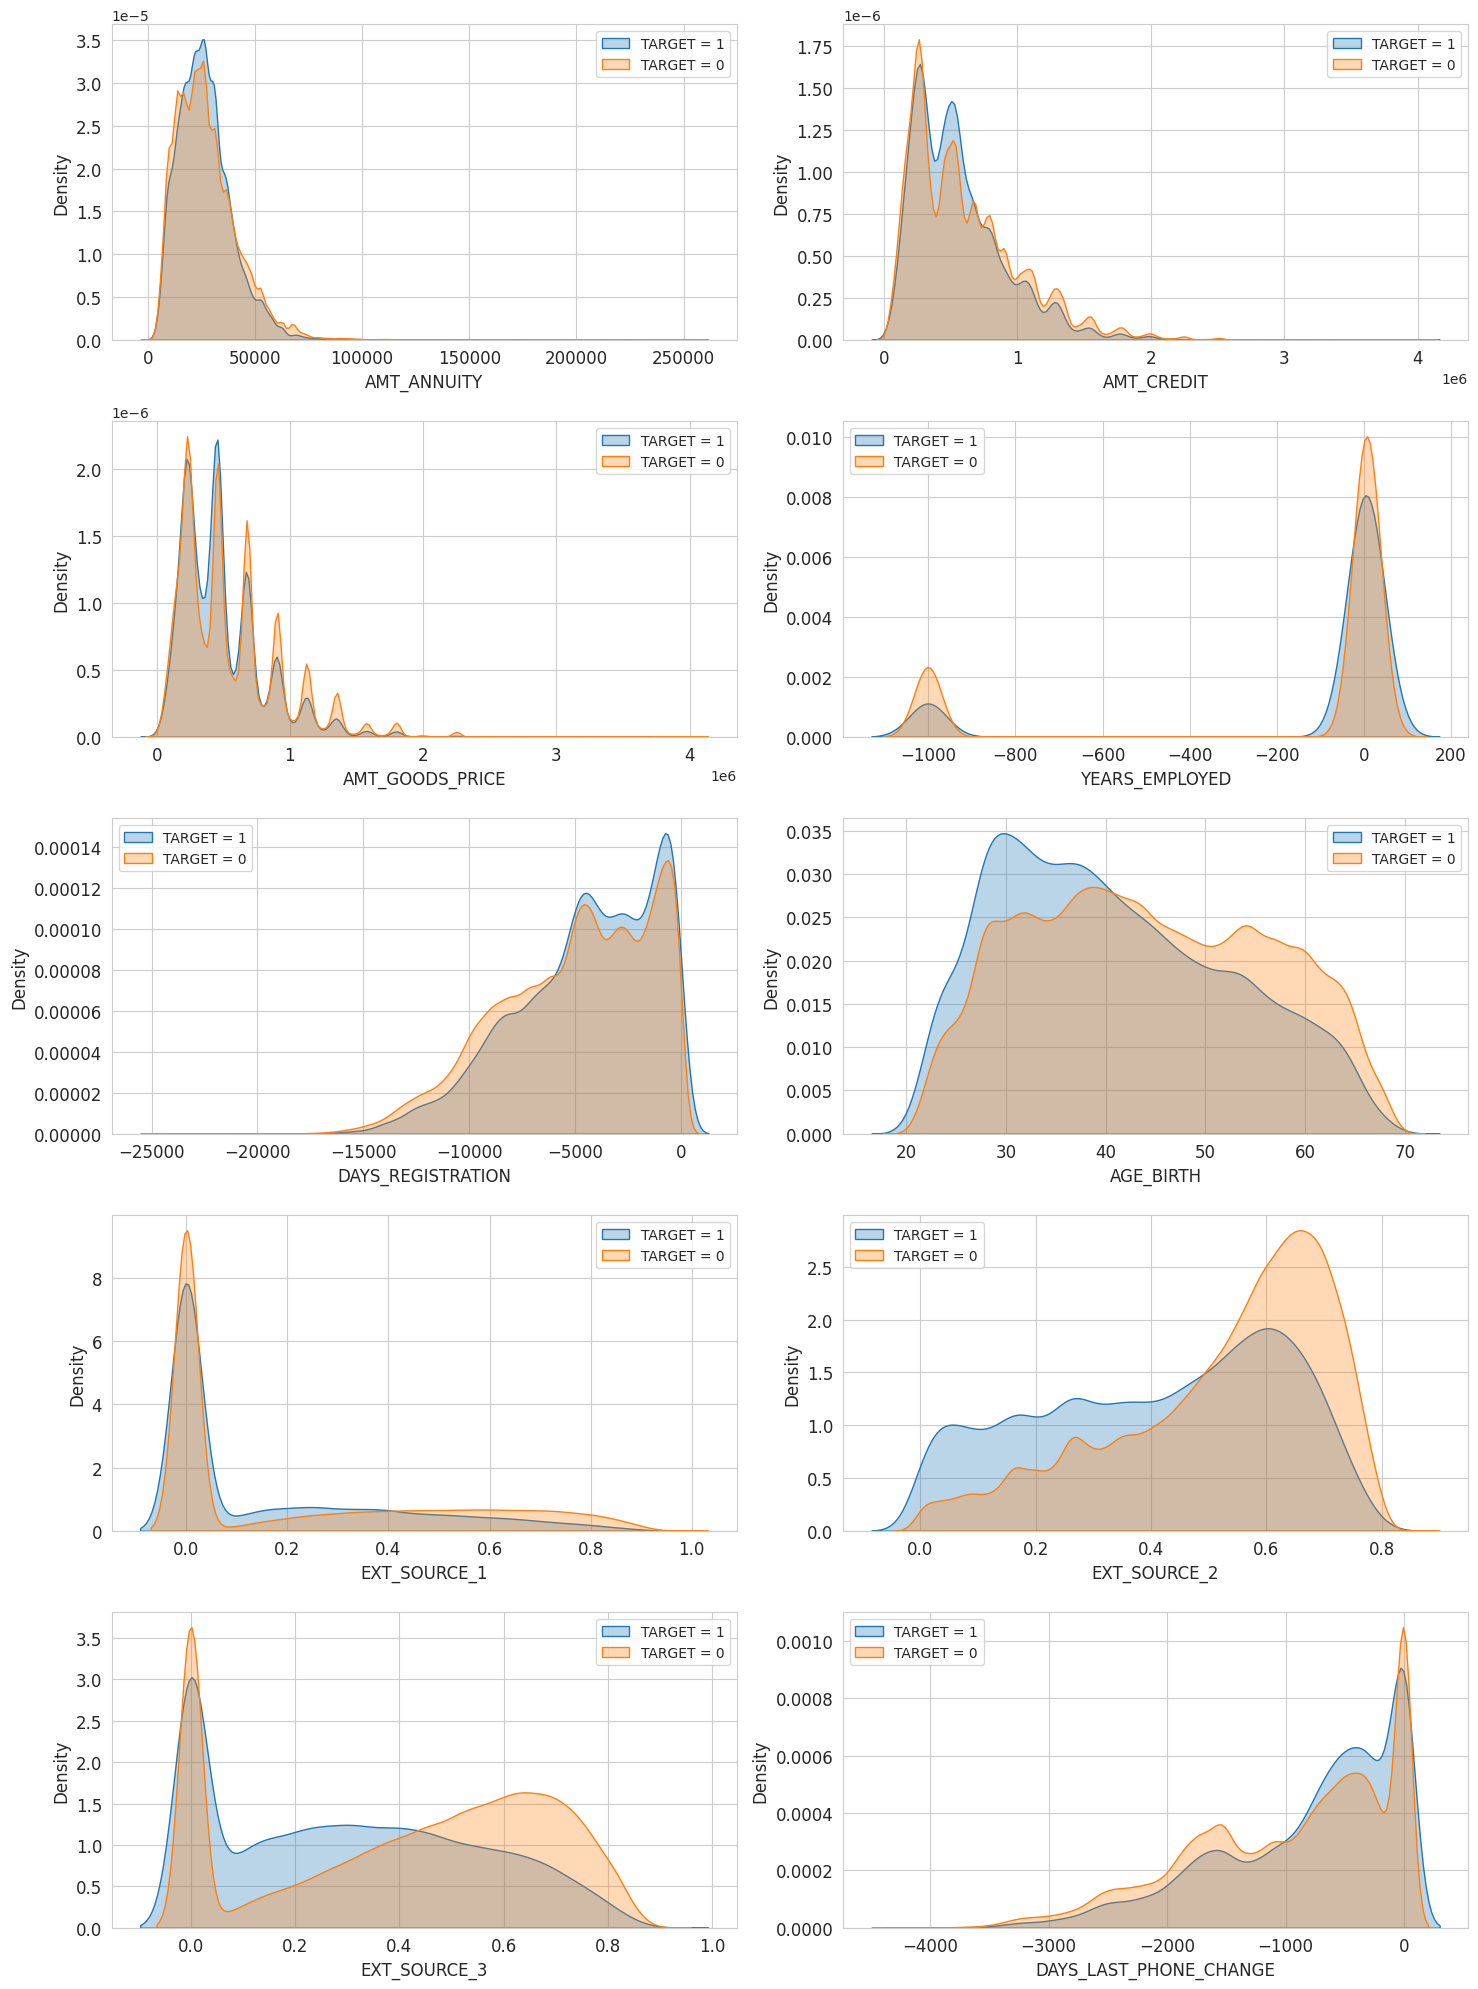

In [45]:
# Analyze numeric variables by TARGET
numeric_vars = [
    'AMT_ANNUITY',
    'AMT_CREDIT',
    'AMT_GOODS_PRICE',
    'YEARS_EMPLOYED',
    'DAYS_REGISTRATION',
    'AGE_BIRTH',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'DAYS_LAST_PHONE_CHANGE'
]
plot_dist_TARGET(app_df, numeric_vars, num_rows=5)

# 4. EDA `bureau`


In [46]:
key = 'bureau'
print(f'Dataframe {key} includes {len(data[key].columns)} features and {data[key].count()} observations.')
data[key].printSchema()

Dataframe bureau includes 17 features and 1716428 observations.
root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- SK_ID_BUREAU: integer (nullable = true)
 |-- CREDIT_ACTIVE: string (nullable = true)
 |-- CREDIT_CURRENCY: string (nullable = true)
 |-- DAYS_CREDIT: integer (nullable = true)
 |-- CREDIT_DAY_OVERDUE: integer (nullable = true)
 |-- DAYS_CREDIT_ENDDATE: double (nullable = true)
 |-- DAYS_ENDDATE_FACT: double (nullable = true)
 |-- AMT_CREDIT_MAX_OVERDUE: double (nullable = true)
 |-- CNT_CREDIT_PROLONG: integer (nullable = true)
 |-- AMT_CREDIT_SUM: double (nullable = true)
 |-- AMT_CREDIT_SUM_DEBT: double (nullable = true)
 |-- AMT_CREDIT_SUM_LIMIT: double (nullable = true)
 |-- AMT_CREDIT_SUM_OVERDUE: double (nullable = true)
 |-- CREDIT_TYPE: string (nullable = true)
 |-- DAYS_CREDIT_UPDATE: integer (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)



In [47]:
# Add prefix to bureau columns
bureau_prefixed = data['bureau'].select([F.col(c).alias(f"BUREAU_{c}") for c in data['bureau'].columns])

# Join with application_train
bureau_merged = data['application_train'].join(
    bureau_prefixed,
    data['application_train'].SK_ID_CURR == bureau_prefixed.BUREAU_SK_ID_CURR,
    how='left_outer'
)

# Count total observations after join
print(f"Total observations after join: {bureau_merged.count()}")

Total observations after join: 1509345


## 4.1. Categorical features

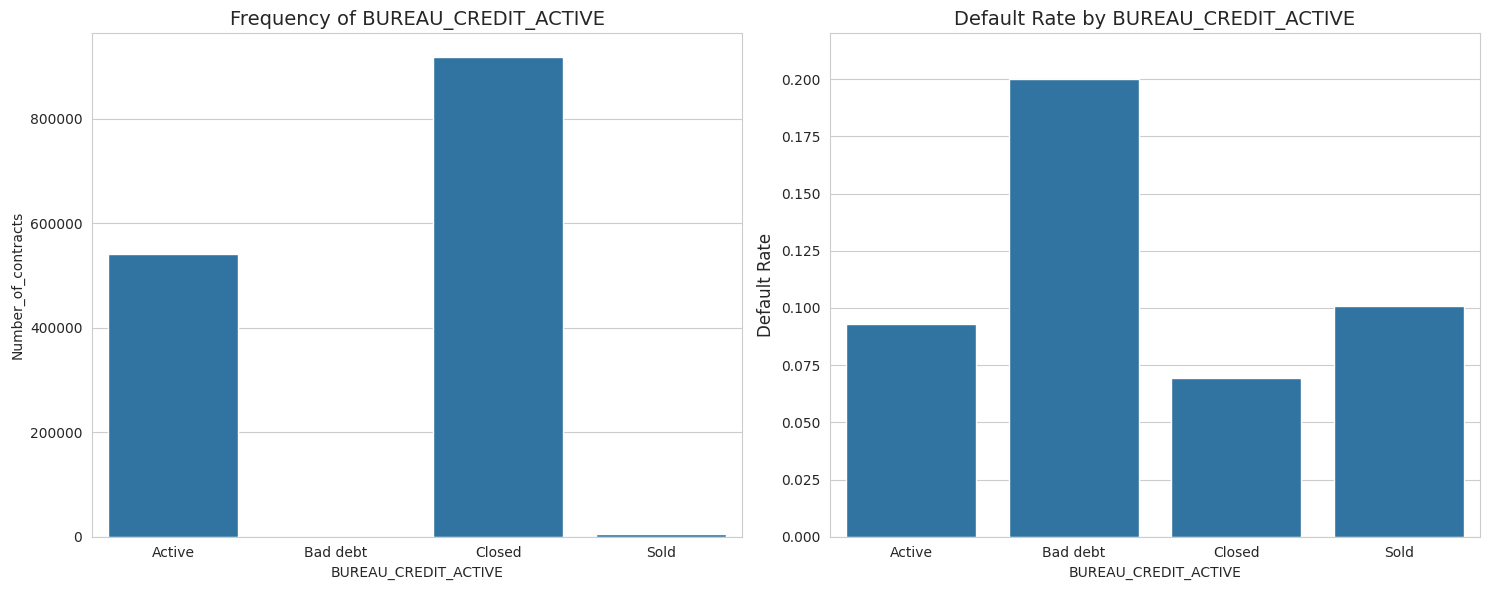

In [48]:
# Credit active status
plot_freq(bureau_merged, 'BUREAU_CREDIT_ACTIVE')

Observations:
- Most credits registered at Credit Bureau are Closed (~900K)
- Active credits account for ~600K
- Bad debt accounts for ~20% of defaults on current applications
- Clients with Closed credits have lowest default rate

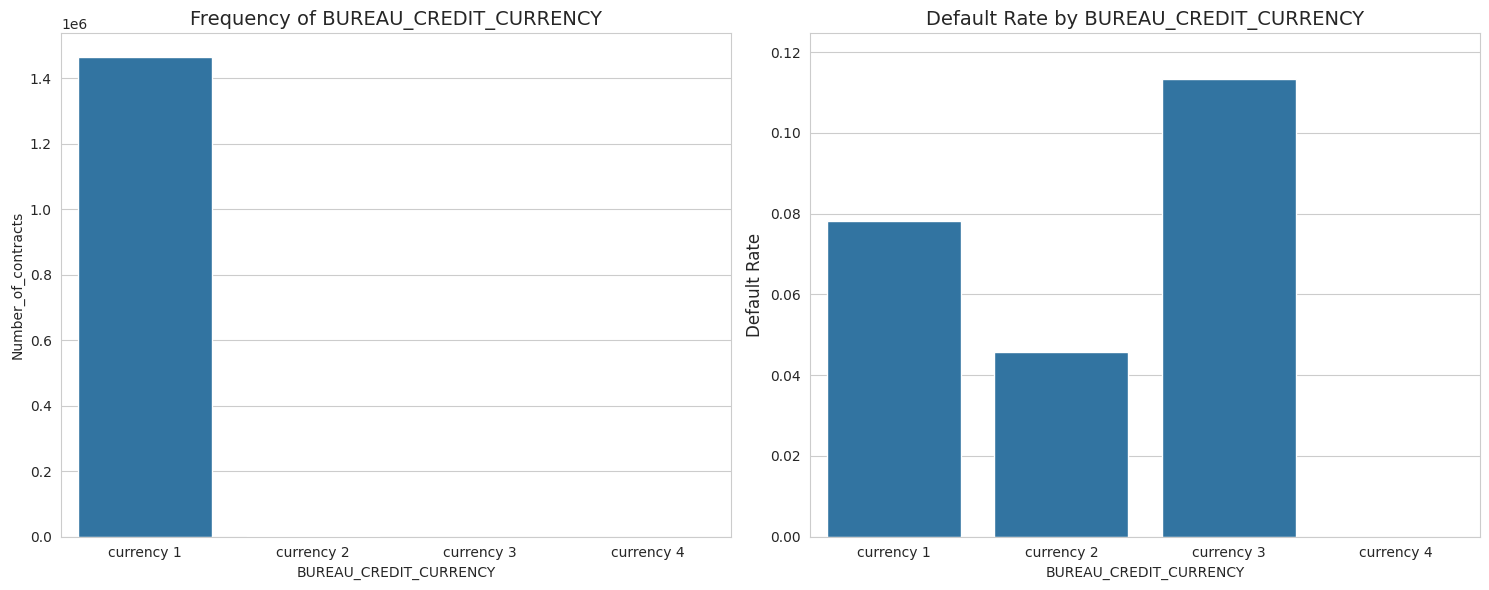

In [49]:
# Credit currency
plot_freq(bureau_merged, 'BUREAU_CREDIT_CURRENCY')

Observations:
- Most credits are in currency_1
- Default rates vary by currency: currency_3 (11%), currency_1 (8%), currency_2 (5%)

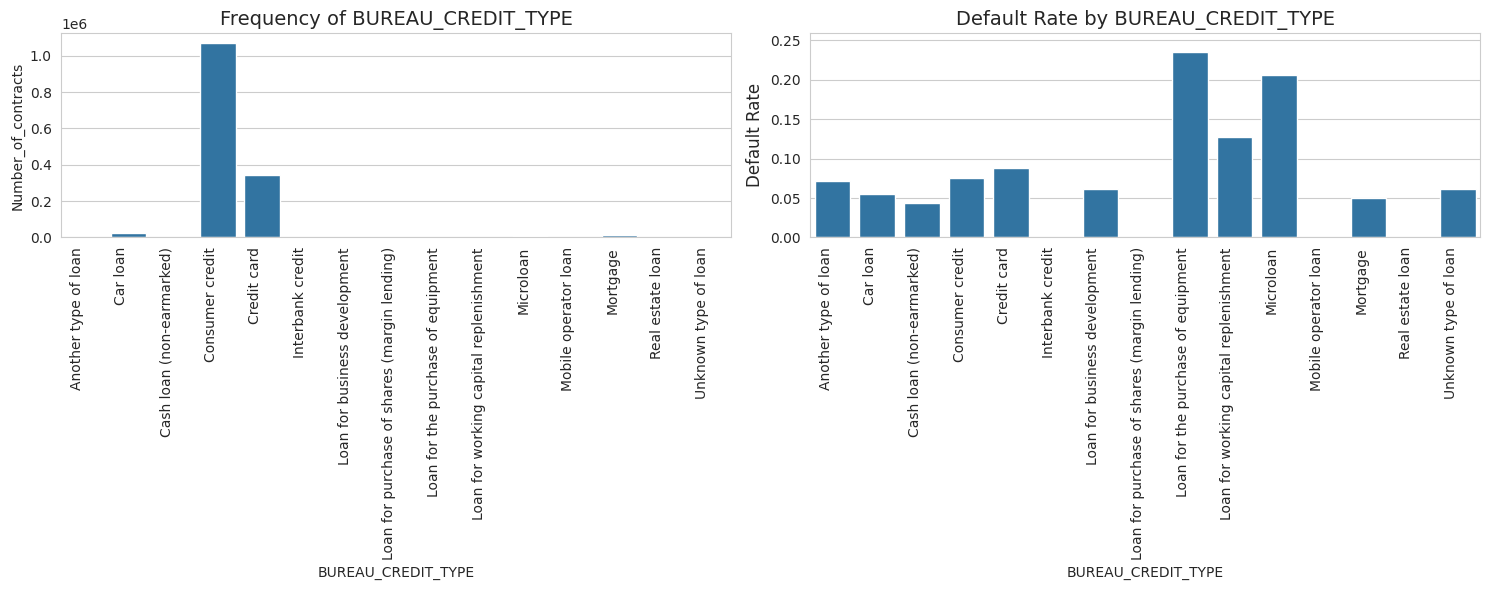

In [50]:
# Credit type
plot_freq(bureau_merged, 'BUREAU_CREDIT_TYPE', True, True)

Observations:
- Majority are Consumer credit and Credit card
- Equipment purchase loans have >20% default rate
- Microloans have >20% default rate
- Working capital loans have >12% default rate

## 4.2. Numerical features

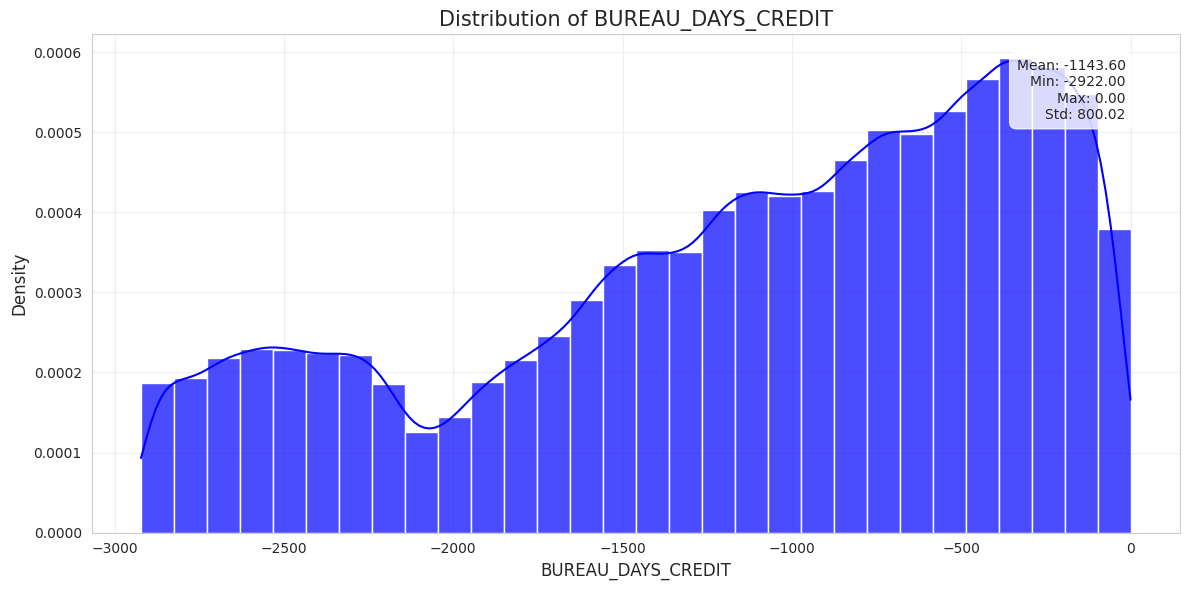

In [51]:
# Days credit
plot_dist(bureau_merged, 'BUREAU_DAYS_CREDIT', 'blue')

Observations:
- Credit duration ranges up to 3000 days
- Peak around 300 days (less than one year)

<Axes: ylabel='Frequency'>

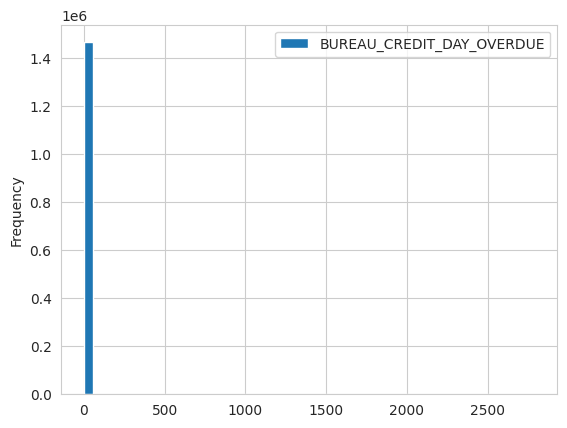

In [52]:
# Days overdue
bureau_merged.select('BUREAU_CREDIT_DAY_OVERDUE').toPandas().plot.hist(bins=50)

Observations:
- Most credits have 0 or very few days overdue
- Maximum overdue is ~3000 days

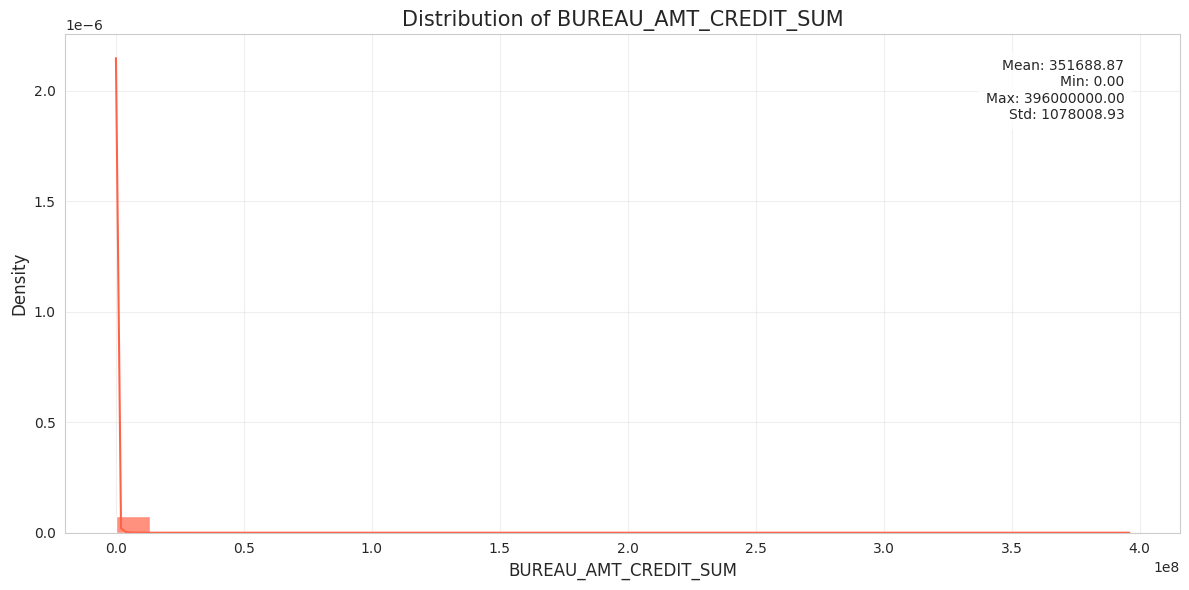

In [53]:
# Credit sum
plot_dist(bureau_merged, 'BUREAU_AMT_CREDIT_SUM', 'tomato')

Observations:
- Distribution shows several peaks
- Maximum concentration around 20,000

Correlation between BUREAU_DAYS_CREDIT and TARGET: 0.0621
Median value for default loans: -726.0000
Median value for non-default loans: -970.0000


Correlation between BUREAU_CREDIT_DAY_OVERDUE and TARGET: 0.0025
Median value for default loans: 0.0000
Median value for non-default loans: 0.0000


Correlation between BUREAU_AMT_CREDIT_SUM and TARGET: -0.0112
Median value for default loans: 112500.0000
Median value for non-default loans: 117000.0000


Correlation between BUREAU_AMT_CREDIT_SUM_LIMIT and TARGET: -0.0051
Median value for default loans: 0.0000
Median value for non-default loans: 0.0000




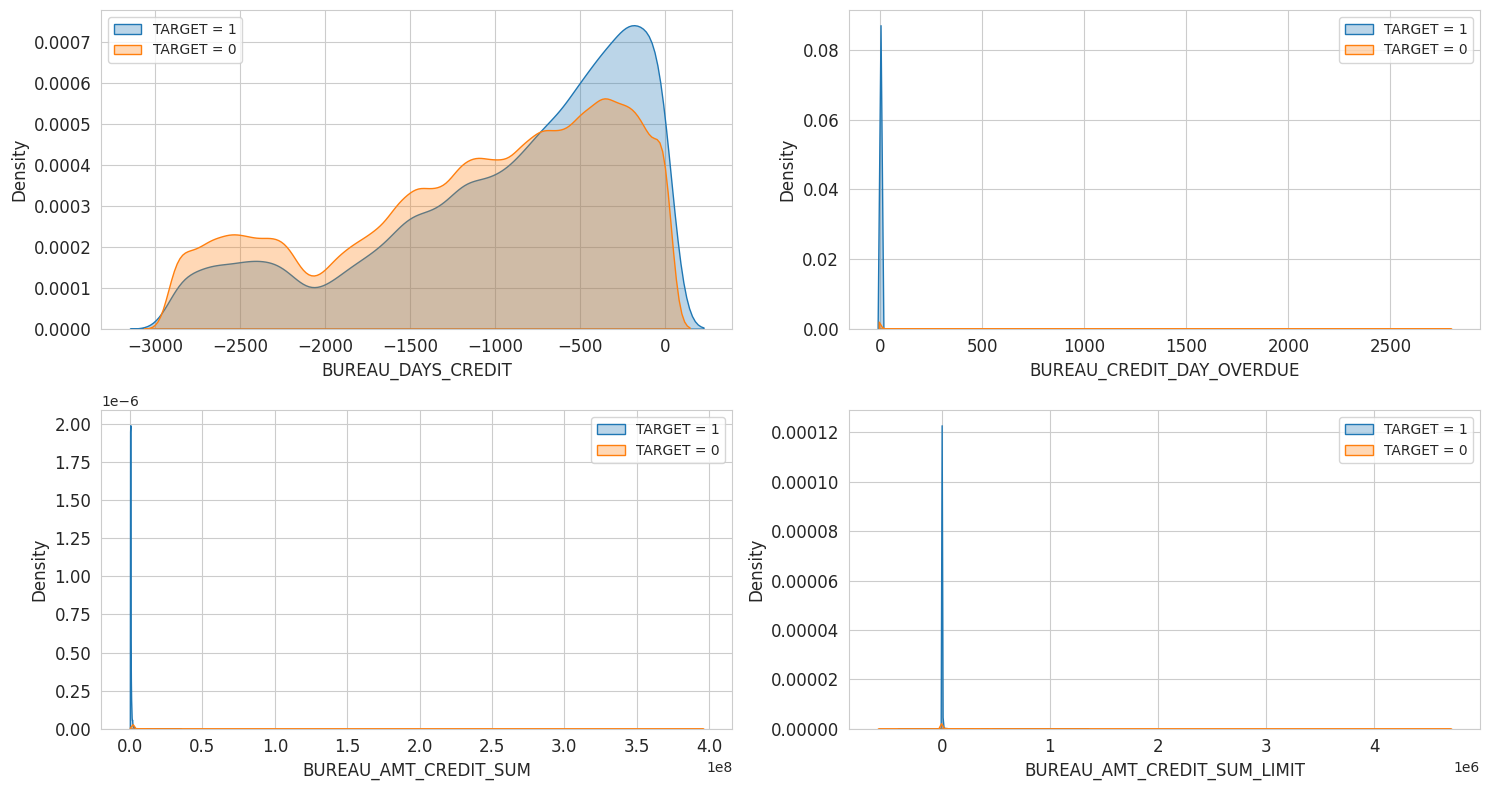

In [54]:
# Analyze bureau numeric variables by TARGET
bureau_numeric_vars = [
    'BUREAU_DAYS_CREDIT',
    'BUREAU_CREDIT_DAY_OVERDUE',
    'BUREAU_AMT_CREDIT_SUM',
    'BUREAU_AMT_CREDIT_SUM_LIMIT'
]
plot_dist_TARGET(bureau_merged, bureau_numeric_vars, num_rows=2)

# 5. EDA `previous_application`

In [55]:
key = 'previous_application'
print(f'Dataframe {key} includes {len(data[key].columns)} features and {data[key].count()} observations.')
data[key].printSchema()

Dataframe previous_application includes 37 features and 1670214 observations.
root
 |-- SK_ID_PREV: integer (nullable = true)
 |-- SK_ID_CURR: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_APPLICATION: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_DOWN_PAYMENT: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- WEEKDAY_APPR_PROCESS_START: string (nullable = true)
 |-- HOUR_APPR_PROCESS_START: integer (nullable = true)
 |-- FLAG_LAST_APPL_PER_CONTRACT: string (nullable = true)
 |-- NFLAG_LAST_APPL_IN_DAY: integer (nullable = true)
 |-- RATE_DOWN_PAYMENT: double (nullable = true)
 |-- RATE_INTEREST_PRIMARY: double (nullable = true)
 |-- RATE_INTEREST_PRIVILEGED: double (nullable = true)
 |-- NAME_CASH_LOAN_PURPOSE: string (nullable = true)
 |-- NAME_CONTRACT_STATUS: string (nullable = true)
 |-- DAYS_DECISION: integer (nullable = true)
 |-- NAME_PAYMEN

In [56]:
# Add prefix to previous application columns
prev_prefixed = data[key].select([F.col(c).alias(f"PREV_{c}") for c in data[key].columns])

# Join with application_train
prev_merged = data['application_train'].join(
    prev_prefixed,
    data['application_train'].SK_ID_CURR == prev_prefixed.PREV_SK_ID_CURR,
    how='left_outer'
)

# Count total observations after join
print(f"Total observations after join: {prev_merged.count()}")

Total observations after join: 1430155


## 5.1. Categorical variables

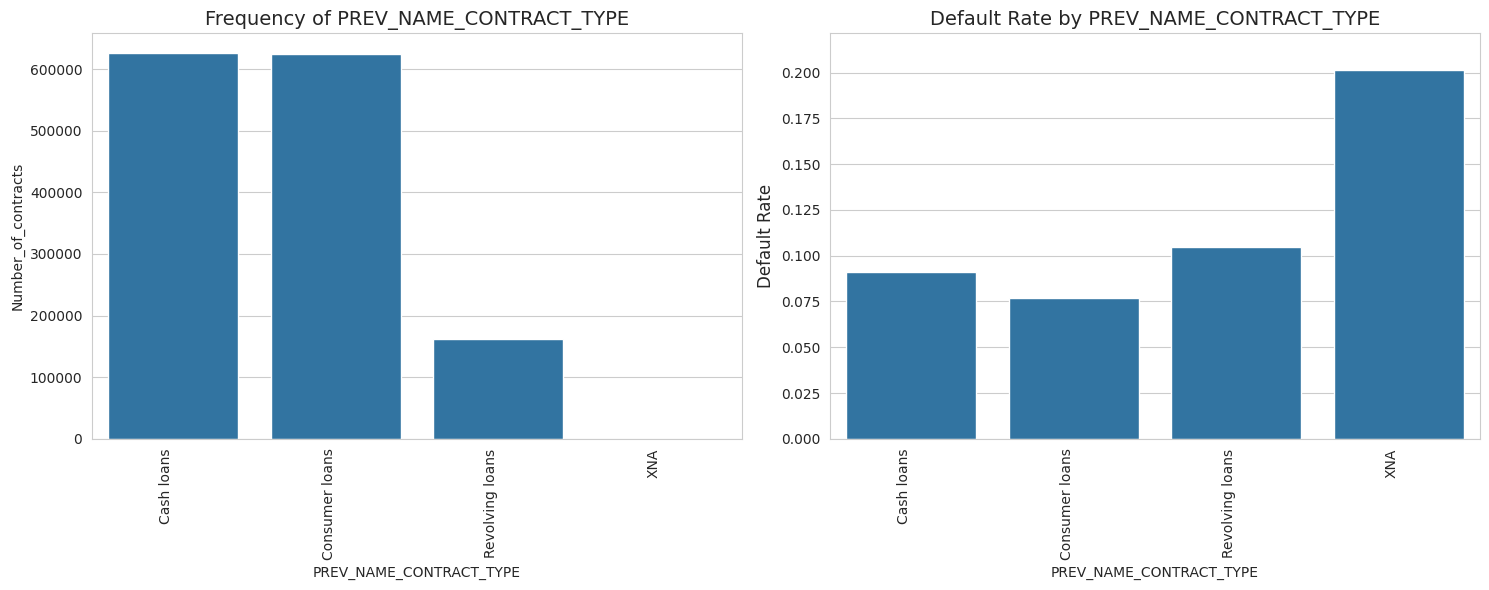

In [57]:
# Contract type
plot_freq(prev_merged, 'PREV_NAME_CONTRACT_TYPE', True, True)

Observations:
- Three types: Cash loans, Consumer loans, Revolving loans
- Cash and Consumer loans each ~600K, Revolving loans ~150K
- Default rates: Revolving loans (10%), Cash loans (9.5%), Consumer loans (8%)

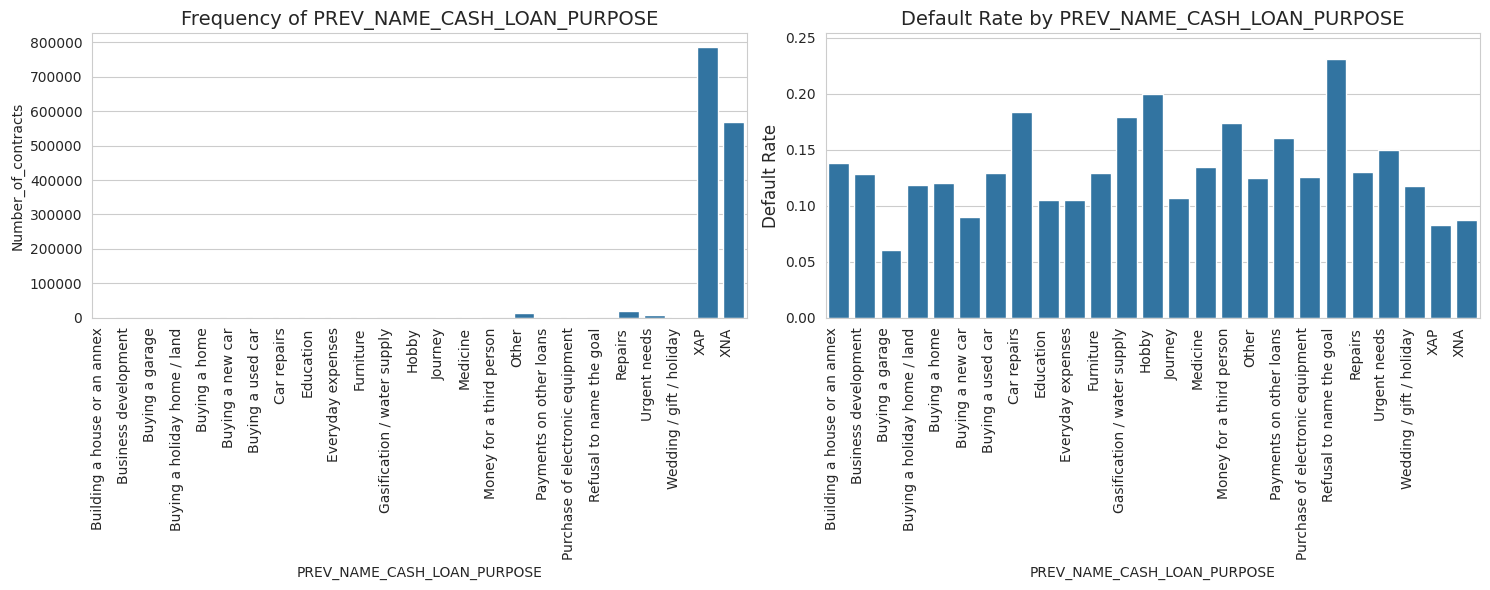

In [58]:
# Cash loan purpose
plot_freq(prev_merged, 'PREV_NAME_CASH_LOAN_PURPOSE', True, True)

Observations:
- Main purposes: Repairs, Other, Urgent needs, Buying used car, Building a house
- Highest default rates: Refusal to name goal (23%), Hobby (20%), Car repairs (18%)

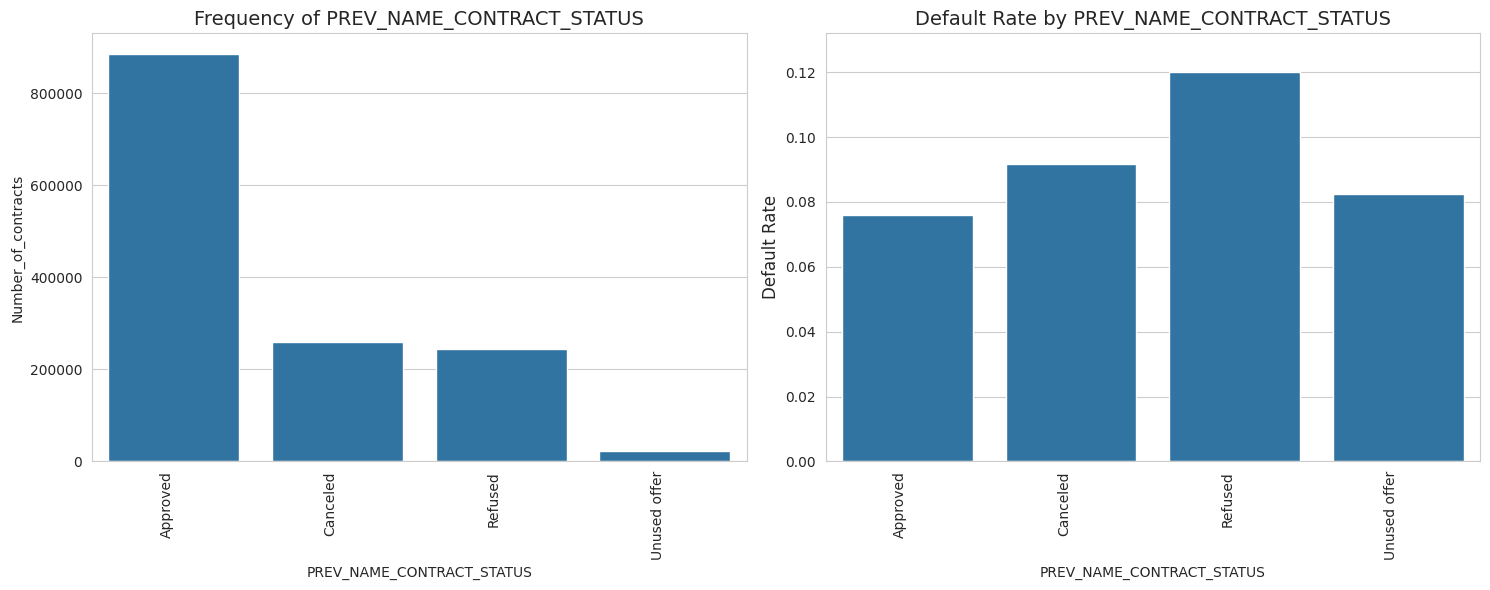

In [59]:
# Contract status
plot_freq(prev_merged, 'PREV_NAME_CONTRACT_STATUS', True, True)

Observations:
- Most are Approved (around 850K), followed by Canceled and Refused (around 240K)
- Highest default rates: Refused (12%), Canceled (9%), Unused offer (8%), Approved (<8%)

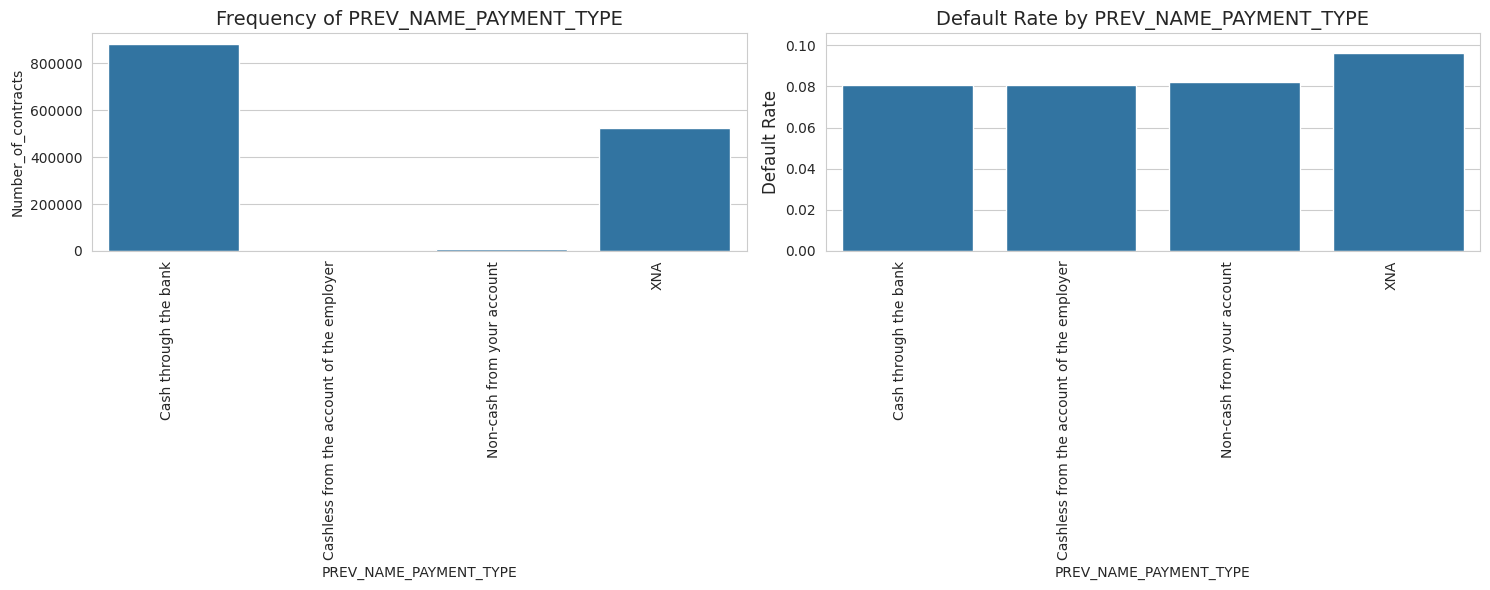

In [60]:
# Payment type
plot_freq(prev_merged, 'PREV_NAME_PAYMENT_TYPE', True, True)

Observations:
- Most paid via Cash through bank (~850K)
- All payment types show similar default rates (~8%)

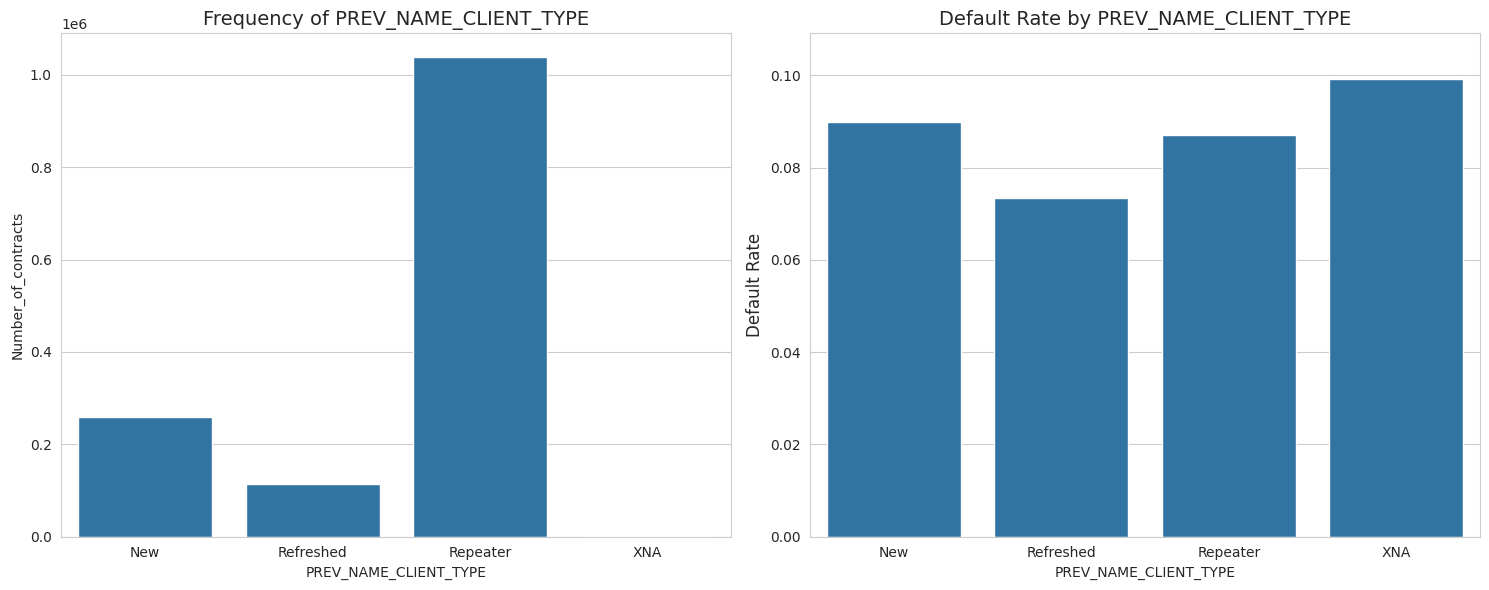

In [61]:
# Client type
plot_freq(prev_merged, 'PREV_NAME_CLIENT_TYPE')

"""
Observations:
- Most are Repeater (around 1M), New (around 200K), Refreshed (a round 100K)
- Default rates: New (8.5%), Repeater (8.25%), Refreshed (7%)
"""

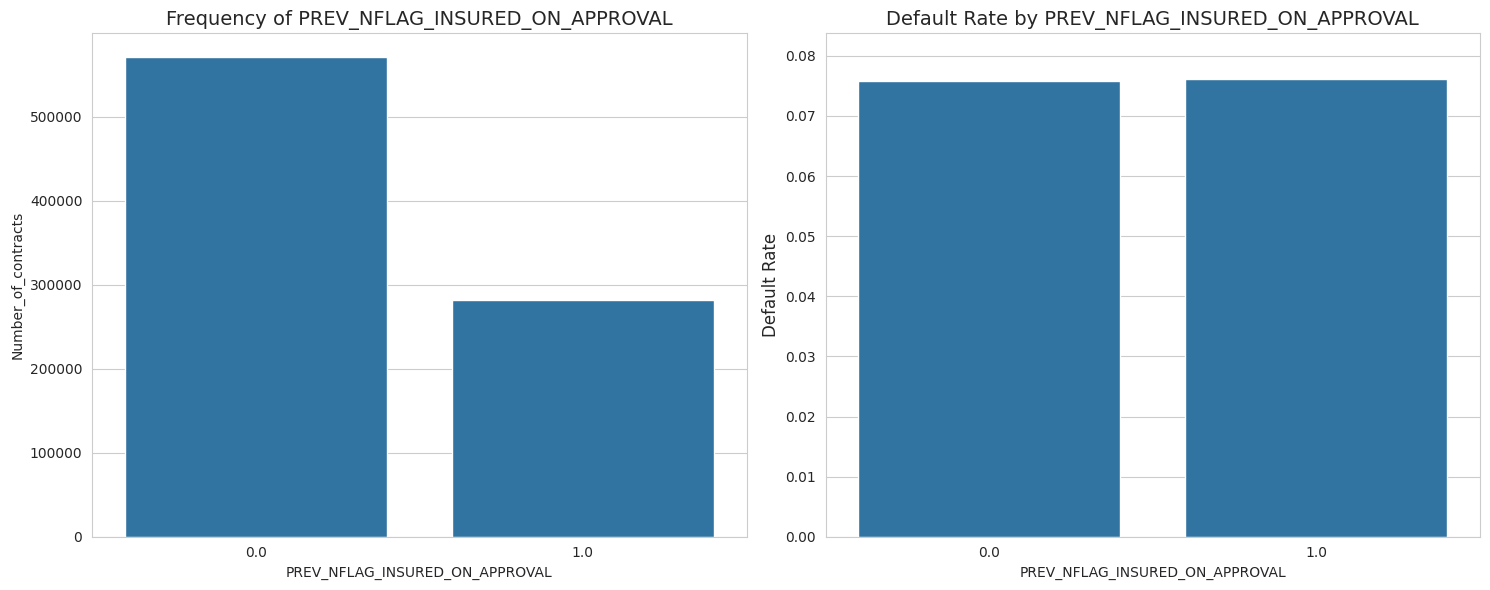

In [62]:
# Insurance flag
plot_freq(prev_merged, 'PREV_NFLAG_INSURED_ON_APPROVAL')

## 5.2. Numerical variables

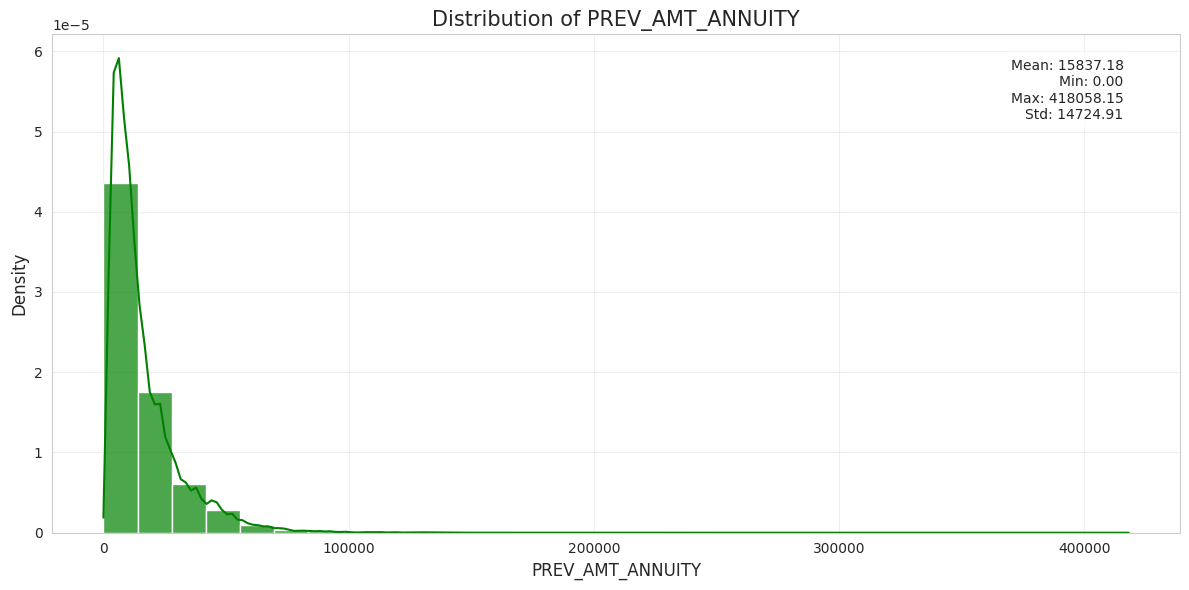

In [63]:
# Annuity amount
plot_dist(prev_merged, 'PREV_AMT_ANNUITY', 'green')

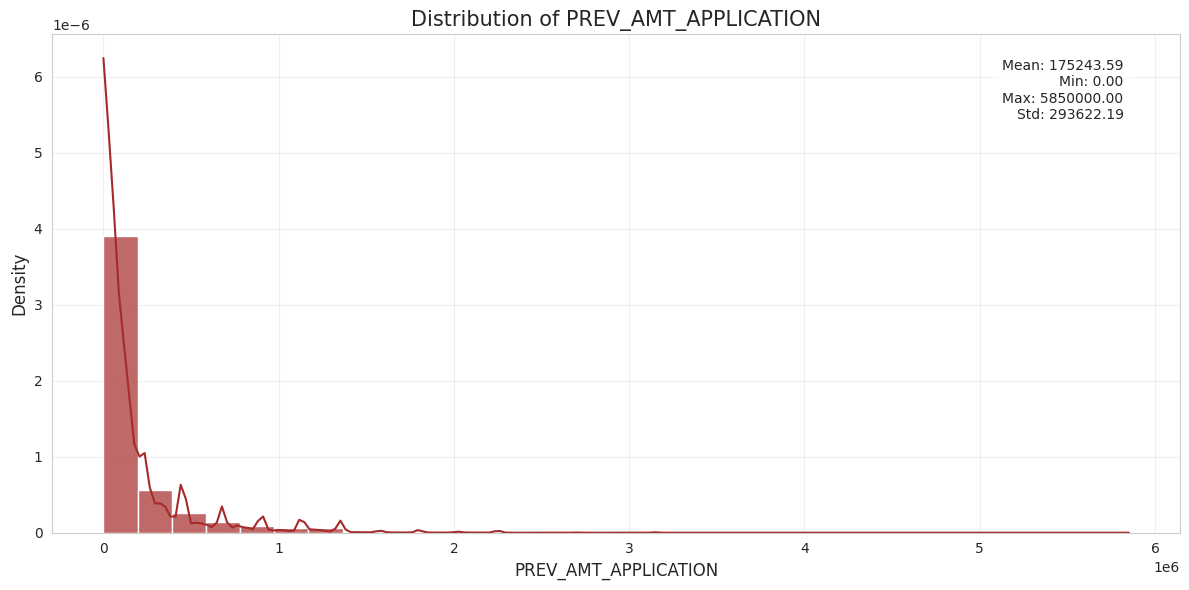

In [64]:
# Application amount
plot_dist(prev_merged, 'PREV_AMT_APPLICATION', 'brown')

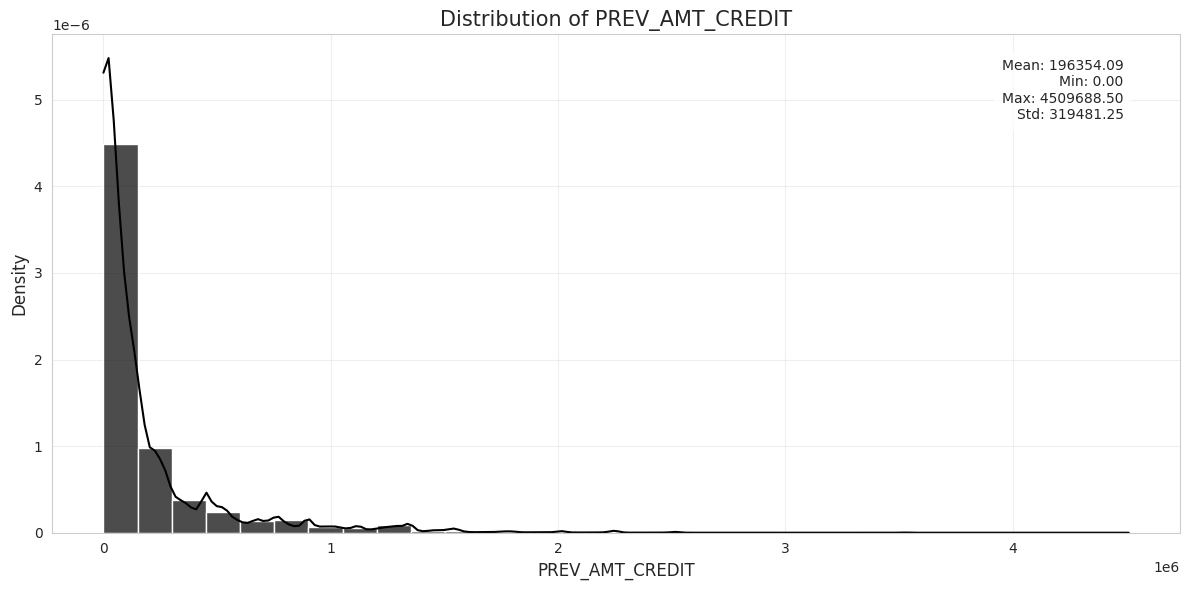

In [65]:
# Credit amount
plot_dist(prev_merged, 'PREV_AMT_CREDIT', 'black')

Correlation between PREV_AMT_ANNUITY and TARGET: -0.0197
Median value for default loans: 7307.8200
Median value for non-default loans: 8160.7950


Correlation between PREV_AMT_APPLICATION and TARGET: -0.0049
Median value for default loans: 65026.8000
Median value for non-default loans: 69525.0000


Correlation between PREV_AMT_CREDIT and TARGET: -0.0017
Median value for default loans: 73314.0000
Median value for non-default loans: 78826.5000


Correlation between PREV_DAYS_FIRST_DUE and TARGET: -0.0101
Median value for default loans: -56.0000
Median value for non-default loans: -288.0000


Correlation between PREV_DAYS_LAST_DUE and TARGET: -0.0017
Median value for default loans: 0.0000
Median value for non-default loans: 0.0000


Correlation between PREV_DAYS_TERMINATION and TARGET: -0.0028
Median value for default loans: 0.0000
Median value for non-default loans: 0.0000




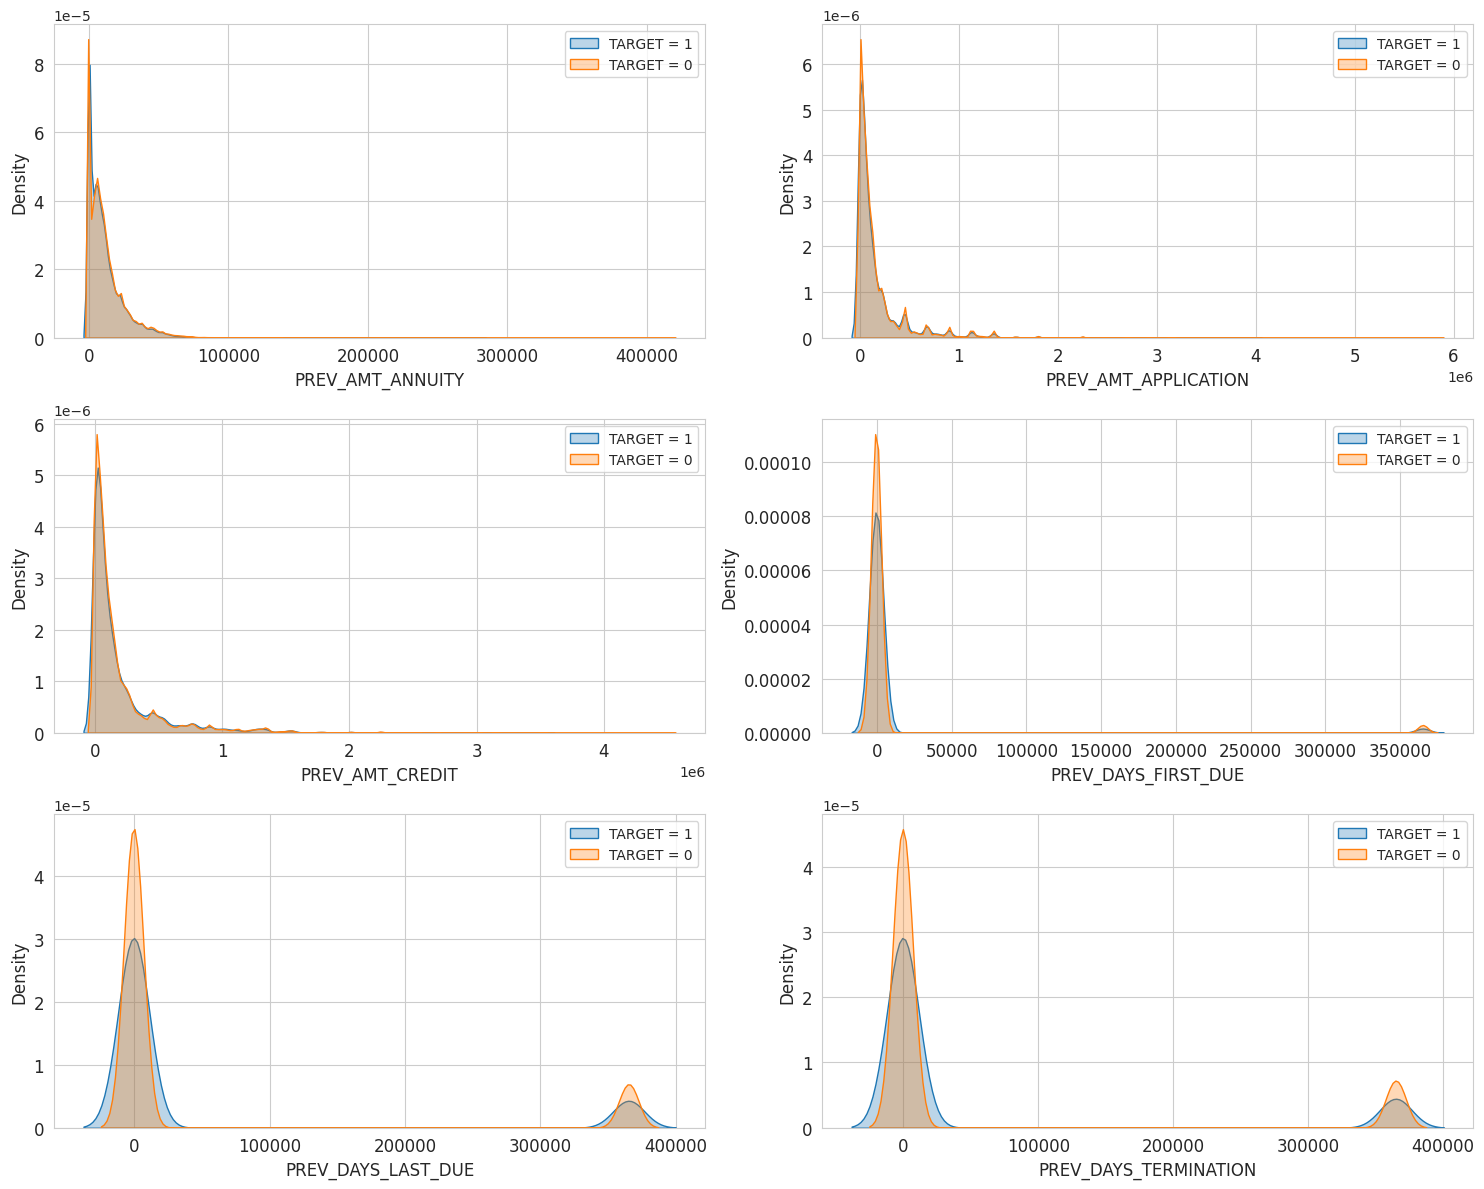

In [66]:
# Analyze previous application numeric variables by TARGET
prev_numeric_vars = [
    'PREV_AMT_ANNUITY',
    'PREV_AMT_APPLICATION',
    'PREV_AMT_CREDIT',
    'PREV_DAYS_FIRST_DUE',
    'PREV_DAYS_LAST_DUE',
    'PREV_DAYS_TERMINATION'
]
plot_dist_TARGET(prev_merged, prev_numeric_vars, num_rows=3)

# 6. Merging final dataset

In [67]:
# Select most important dataframes based on analysis
final_dataframes = [
    'application_train',
    'bureau',
    'previous_application'
]

# Select important columns from application_train
cols_application_train = [
    'SK_ID_CURR',
    'TARGET',
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'CNT_CHILDREN',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'OCCUPATION_TYPE',
    'CNT_FAM_MEMBERS',
    'REG_REGION_NOT_LIVE_REGION',
    'REG_REGION_NOT_WORK_REGION',
    'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY',
    'ORGANIZATION_TYPE',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'DAYS_LAST_PHONE_CHANGE'
]

# Select important columns from bureau
cols_bureau = [
    'SK_ID_CURR',
    'SK_ID_BUREAU',
    'CREDIT_ACTIVE',
    'DAYS_CREDIT',
    'DAYS_CREDIT_ENDDATE',
    'AMT_CREDIT_SUM',
    'AMT_CREDIT_SUM_OVERDUE',
    'CREDIT_TYPE'
]

# Select important columns from previous_application
cols_previous_application = [
    'SK_ID_PREV',
    'SK_ID_CURR',
    'NAME_CONTRACT_TYPE',
    'AMT_ANNUITY',
    'AMT_APPLICATION',
    'AMT_CREDIT',
    'AMT_GOODS_PRICE',
    'NAME_CONTRACT_STATUS',
    'NAME_CLIENT_TYPE',
    'DAYS_LAST_DUE',
    'DAYS_TERMINATION',
    'NFLAG_INSURED_ON_APPROVAL'
]

# List of columns to keep for each dataframe
columns_to_keep = [cols_application_train, cols_bureau, cols_previous_application]

In [69]:
# Dictionary to store filtered dataframes
filtered_data = {}

# Read and filter dataframes
for idx, file in enumerate(final_dataframes):
    if file in filtered_data.keys():
        print(f'{file} already exists in dictionary')
    else:
        filepath = '/content/drive/MyDrive/Home_Credit/'+f'{file}.csv'
        filtered_df = spark.read.csv(
            filepath,
            header=True,
            sep=',',
            inferSchema=True
        ).select(columns_to_keep[idx])
        filtered_data[file] = filtered_df

In [70]:
# Add prefix to bureau columns for joining
bureau_prefixed = filtered_data['bureau'].select([F.col(c).alias(f"BUREAU_{c}") for c in filtered_data['bureau'].columns])

# Add prefix to previous application columns for joining
prev_app_prefixed = filtered_data['previous_application'].select([F.col(c).alias(f"PREV_{c}") for c in filtered_data['previous_application'].columns])

In [71]:
# Join application_train and bureau
merged_df = filtered_data['application_train'].join(
    bureau_prefixed,
    filtered_data['application_train'].SK_ID_CURR == bureau_prefixed.BUREAU_SK_ID_CURR,
    how='left_outer'
)

# Join previous_application
final_df = merged_df.join(
    prev_app_prefixed,
    merged_df.SK_ID_CURR == prev_app_prefixed.PREV_SK_ID_CURR,
    how='left_outer'
)

# Count final observations
print(f"Final dataset has {final_df.count()} observations")

Final dataset has 8091522 observations


In [72]:
# Check number of distinct applicants
distinct_applicants = final_df.select(F.countDistinct("SK_ID_CURR")).collect()[0][0]
print(f"Number of distinct applicants: {distinct_applicants}")

Number of distinct applicants: 307511


In [ ]:
# Save final dataset to parquet file
final_df.write.mode("overwrite").parquet('/content/drive/MyDrive/Home_Credit/train.parquet')

In [75]:
# Stop Spark session
spark.stop()